# Exercise 3

Work on this before the next lecture on 1 May. We will talk about questions, comments, and solutions during the exercise after the third lecture.

Please do form study groups! When you do, make sure you can explain everything in your own words, do not simply copy&paste from others.

The solutions to a lot of these problems can probably be found with Google. Please don't. You will not learn a lot by copy&pasting from the internet.

If you want to get credit/examination on this course please upload your work to **your GitHub repository** for this course **before** the next lecture starts and post a link to your repository [in this thread](). If you worked on things together with others please add their names to the notebook so we can see who formed groups.

---

These are some useful default imports for plotting and [`numpy`](http://www.numpy.org/)

In [ ]:
%config InlineBackend.figure_format='retina'
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14
from sklearn.utils import check_random_state

---

## Question 1

Finding analytic gradients of expressions. Use the backprop framework we built in the lecture to compute the analytic gradient of an expression. This is useful to get thinking about
writing computations as graphs and to see first hand that there is no magic involved
in automatically finding derivatives.

For example, using the expression: $f(x) = \sin(x^2)$: implement a module for $\sin(x)$, build the graph representing the function, plot the expression as well as the gradient as a function of $x$.

* add a new operation (e.g. $\sin, \cos, \exp, x^y$, ...) to the `Addition` and `Multiply` modules.
* build a new expression using the available expressions
* plot your expression as well as its gradient
* compare the gradient to one you worked out by hand (or some other software package)

ps. if you want to use automatic differentiation for serious projects outside of neural
network projects checkout packages like https://github.com/HIPS/autograd

In [2]:
class Multiply:
    def forward(self, x, y):
        self.x = x
        self.y = y
        return x * y
    
    def backward(self, dLdz):
        dzdx = self.y
        dLdx = dLdz * dzdx
        
        dzdy = self.x
        dLdy = dLdz * dzdy
        return [dLdx, dLdy]


class Add:
    def forward(self, x, y):
        self.x = x
        self.y = y
        return x + y
        
    def backward(self, dLdz):
        dzdy = 1
        dzdx = 1
        return [dLdz * dzdy, dLdz * dzdx]

In [8]:
def f_with_gradients(x, y, z):
    """ Implements (x+y)*z """
    q = Add()
    f = Multiply()
    
    q_out = q.forward(x, y)
    f_out = f.forward(q_out, z)
    
    # suppose L = u
    # u = (x+y)*z
    # let f(a,b) = a*b
    # q(a,b) = a + b
    # then
    # L = f( q(x,y), z )
    # dL = [ df/dq*dq/dx, df/dq*dq/dy, df/dz]
    # dL = [ z, z, x+y]
    grad_f = f.backward(1.)
    grad_q = q.backward(grad_f[0])

    # return [dL/dx, dL/dy, dL/dz]
    gradients = [grad_q[0], grad_q[1], grad_f[1]]
    return f_out, gradients

In [11]:
x = np.array([0.,1.,2.])
y = np.array([1.,3.,5.])
z = np.array([0.,1.,2.])
L = f_with_gradients(x, y, z)
# L = (x+y)*z
# dL = [ df/dq*dq/dx, df/dq*dq/dy, df/dz]
# dL = [ z, z, x+y]
print(L)

(array([  0.,   4.,  14.]), [array([ 0.,  1.,  2.]), array([ 0.,  1.,  2.]), array([ 1.,  4.,  7.])])


In [12]:
class Square:
    def forward(self, x):
        self.x = x
        return x**2
    
    def backward(self, dLdz):
        dzdx = 2*self.x
        return dLdz*dzdx
        
class Sin:
    def forward(self,x):
        self.x = x
        return np.sin(x)

    def backward(self, dLdz):
        dzdx = -np.cos(self.x)
        return dLdz*dzdx

In [14]:
def graph_sin_x_squared(x):
    f = Sin()
    q = Square()
    
    q_out = q.forward(x)
    f_out = f.forward(q_out)
    
    grad_f = f.backward(1.)
    grad   = q.backward(grad_f)
    
    return f_out, grad

test by computing
$ f = sin(x^2), x = \sqrt{\pi} $

which should yield
$ f = sin(\pi) = 0 $
and
$ \frac{df}{dx} = -2\sqrt{\pi}cos(\pi) = 2\sqrt{\pi} $

In [21]:
#print(2.0*np.sqrt(np.pi))
print(graph_sin_x_squared(np.sqrt(np.pi)))
assert( np.abs( graph_sin_x_squared(np.sqrt(np.pi))[1] / (2.0*np.sqrt(np.pi)) - 1) < 0.001 )

(5.6655388976479796e-16, 3.5449077018110318)


---

## Question 2

Use the circle data set from exercise 1 and build a neural network classifier that can solve the problem (scikit-learn provides a MLPClassifier classifier that implements a neural network). Comment on:

* what is the minimum number of layers
* what is the minimum width of each layer
* does the answer change if you provide polynomial features?
* thinking about how NNs distort and transform the problem space, can you create
  a visualisation of what it is the network is doing to make this problem linearly
  separable?
* is there a difference between using the tanh and ReLU activation functions?

## Summary of results

### Influence of number of layers and width of each layer using SGD

I have experimented with 1 and 2 layers. Below I plot the scores
- for a single layer:
 <img src="images/single_layer_MLP.png" />
- for two layers:
 <img src="images/two-layers_MLP.png" />

#### Single layer MLP

After some trial and error, I have found that with a single layer, **only 4 neurons** are required to get decent results and a good-looking decision surface.

<img src="images/single-layer-surface.png"/>

#### Two-layer MLP

I was very surprised to find that adding a second layer can actually decrease the accuracy of the network! For example, the single-layer-with-4-neurons network above obtained about 100% accuracy, however a 
two-layer-with-(4,1)-neurons only achieves 50% score!
_A posteriori_ this makes sense, because in a way you are funneling all the information into a single neuron in the second layer, which can't be good. However, a two-layer-with-(4,1)-neurons networks achieves slightly better performance than the single layer one.

The best scoring network required layers of (4,4) neurons.

### Using Adam solver

doesn't change much in this case, probably because the example is very simple. Here are the same plots from above:
 <img src="images/single_layer_MLP_adam.png" />
 <img src="images/two-layers_MLP_adam.png" />
 <img src="images/single-layer-surface_adam.png"/>

### Using polynomial features

as expected, using polynomial features improves drastically the accuracy-cost tradeoff, in the sense that we can get very high accuracy with only a very limited number of neurons.

Indeed, a single layer with a single neuron is sufficient to get optimal accuracy! As stated before, and perhaps surprisingly, two layers with a single neuron each perform very badly.

### Visualize how the network distorts the space

To be able to do this, I created a network that satisfies the following two properties:
- gets good accuracy;
- last layer has only 2 neurons.

In this way, I was able to easily visualize how the input to an MLP is transformed into an output, just before classification.

NOTE: I went back to using the original features, since the polynomial features make this problem trivial.

Here's how the 2-dimensional hidden space looks like after application of a (4,4,2) network:
N.B I am plotting the test data, not the train data
N.B.2 I am actually plotting the "inputs" to the last layer, i.e. I am not calculating the ReLu function on the last layer. 

<img src="images/distorted_without_final_relu.png" />

With some imagination, we can see something similar to the polynomial features happening, where the classes of one label tend to cluster in a specific area of the feature space.

### Switching to tanh activation

For this dataset, switching to tanh function reveals to be very beneficial. Indeed, it is possible to create a much smoother looking decision surface with a smaller network of (3,2) neurons. Here is what it looks like:

<img src="images/tanh-surface.png" />

By using the same technique as before, we can see how datapoints with the same label end up being classified in specific corners of the feature space.

<img src="images/distorted_without_final_relu_tanh.png" />

For a more funky look, we can try to visualize how the test data gets transformed by using arrows:

<img src="images/space_distortion_arrows.png" />

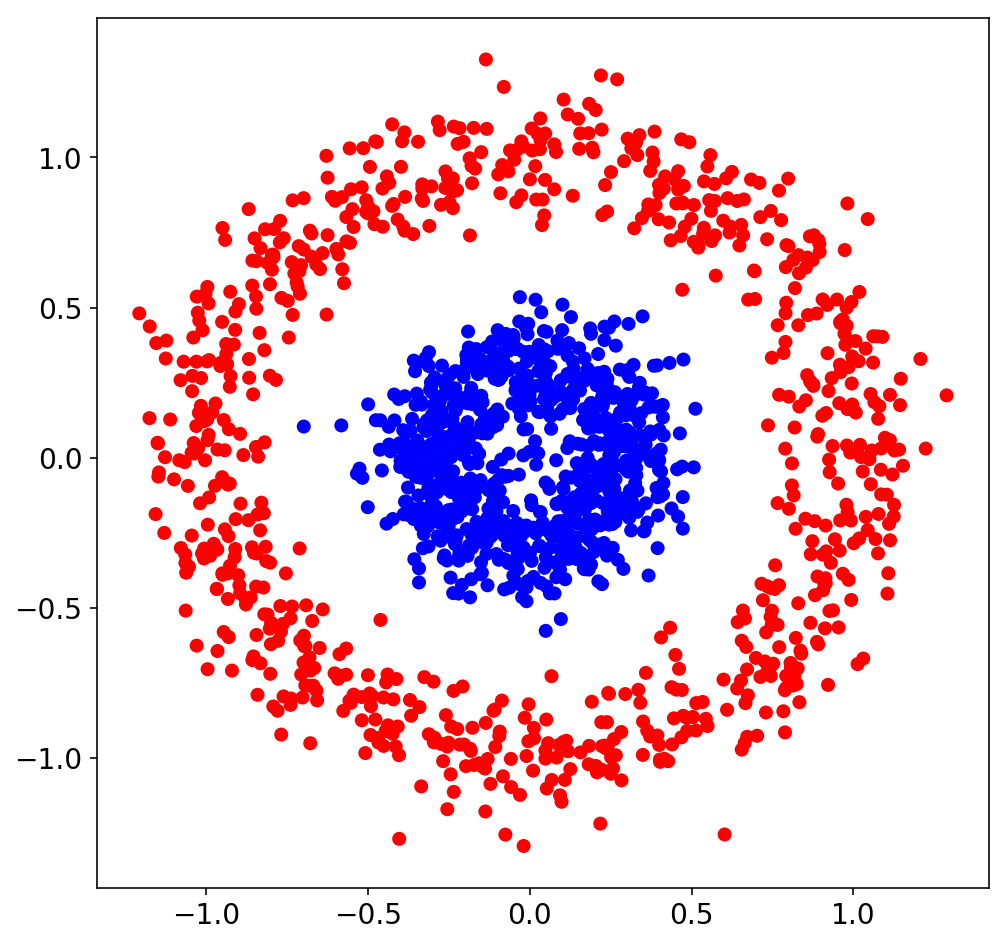

In [266]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1600, factor=.3, noise=.1)
labels = ['b', 'r']
y = np.take(labels, (y < 0.5))

plt.scatter(X[:,0], X[:,1], c=y)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, random_state=42)

In [102]:
from sklearn.neural_network import MLPClassifier

# NETWORK TOPOLOGY
hidden_layer_sizes=(2, )

# ACTIVATION FUNCTION
activation='relu'

# SOLVER
solver='adam'
#solver='sgd'

# L2 REGULARIZATION PARAMETER
alpha=0.0001

# LEARNING RATE
#batch_size='auto'
#learning_rate='constant'
learning_rate_init=0.1
max_iter=500


# REPRODUCIBILITY
random_state = 42

nnet = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, 
                     activation=activation, 
                     solver=solver,
                     alpha=alpha,
                     learning_rate_init=learning_rate_init,
                     max_iter=max_iter,
                     random_state=random_state)

In [103]:
# TEST TO FIT THE MODEL
nnet.fit(X_train, y_train)
print(nnet.score(X_test,y_test))

0.6640625


In [109]:
from sklearn.neural_network import MLPClassifier
scores = []

# ACTIVATION FUNCTION
activation='relu'

# SOLVER
solver='adam'
#solver='sgd'

# L2 REGULARIZATION PARAMETER
alpha=0.0001

# LEARNING RATE
#batch_size='auto'
#learning_rate='constant'
learning_rate_init=0.1
max_iter=500


# REPRODUCIBILITY
random_state = 42

layer_sizes = range(1,15)

for single_layer_size in layer_sizes:
    hidden_layer_sizes=(single_layer_size, )
    nnet = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, 
                     activation=activation, 
                     solver=solver,
                     alpha=alpha,
                     learning_rate_init=learning_rate_init,
                     max_iter=max_iter,
                     random_state=random_state)
    
    nnet.fit(X_train, y_train)
    scores.append( nnet.score(X_test,y_test) )

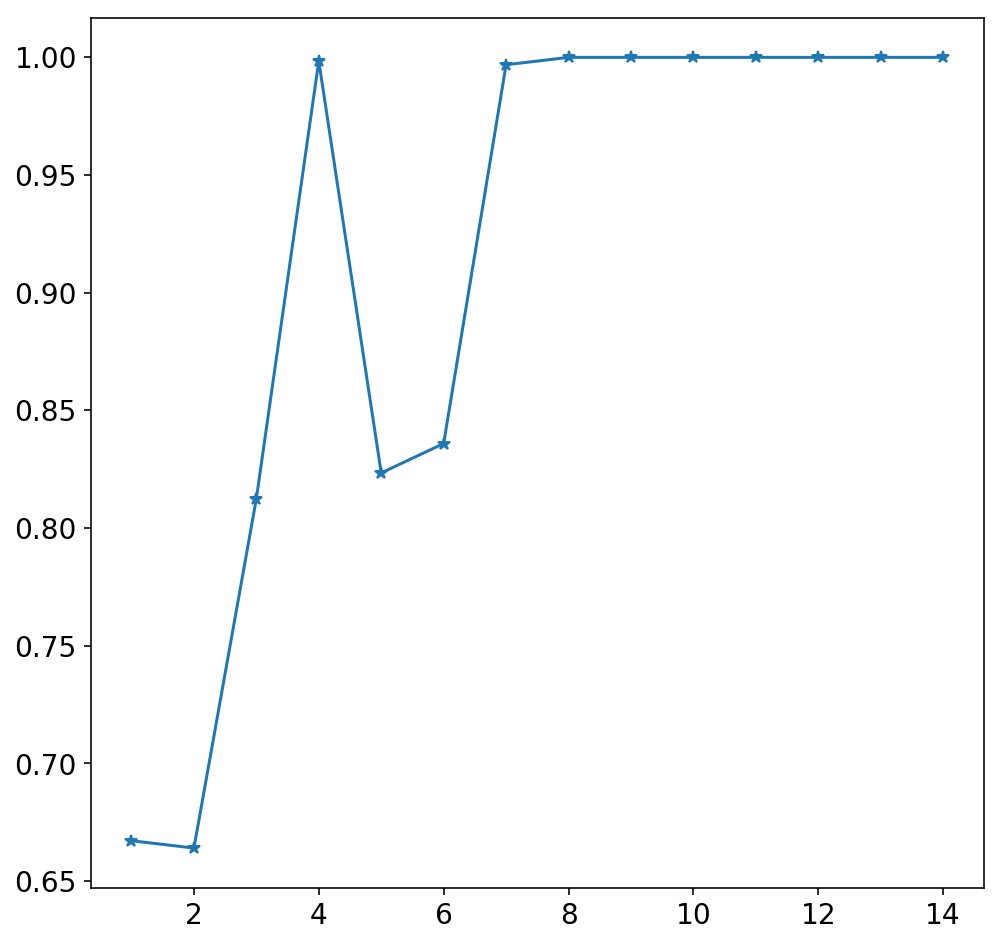

In [110]:
plt.plot(layer_sizes, scores, '-*')
      
#plt.savefig('images/single_layer_MLP_adam.png')

In [111]:
from sklearn.neural_network import MLPClassifier

# ACTIVATION FUNCTION
activation='relu'

# SOLVER
solver='adam'
#solver='sgd'

# L2 REGULARIZATION PARAMETER
alpha=0.0001

# LEARNING RATE
#batch_size='auto'
#learning_rate='constant'
learning_rate_init=0.1
max_iter=500


# REPRODUCIBILITY
random_state = 42

layer_sizes = range(1,8)
scores = np.zeros(shape=(len(layer_sizes), len(layer_sizes)))

for i,single_layer_size_i in enumerate(layer_sizes):
    for j,single_layer_size_j in enumerate(layer_sizes):
        hidden_layer_sizes=(single_layer_size_i,single_layer_size_j)
        nnet = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, 
                         activation=activation, 
                         solver=solver,
                         alpha=alpha,
                         learning_rate_init=learning_rate_init,
                         max_iter=max_iter,
                         random_state=random_state)

        nnet.fit(X_train, y_train)
        scores[i][j] = nnet.score(X_test,y_test)


[[ 0.5015625  0.4984375  0.84375    0.825      0.671875   0.7890625
   0.6734375]
 [ 0.6671875  0.5015625  0.4984375  0.6703125  0.5015625  0.6703125
   0.665625 ]
 [ 0.5015625  0.6546875  0.8140625  0.5015625  0.80625    0.8171875
   0.809375 ]
 [ 0.4984375  0.5015625  0.83125    0.996875   0.9921875  0.99375    1.       ]
 [ 0.5015625  0.8265625  0.996875   0.8421875  0.996875   1.         0.8296875]
 [ 0.5015625  0.8359375  0.921875   0.996875   0.996875   0.84375    1.       ]
 [ 1.         1.         1.         1.         1.         1.         1.       ]]


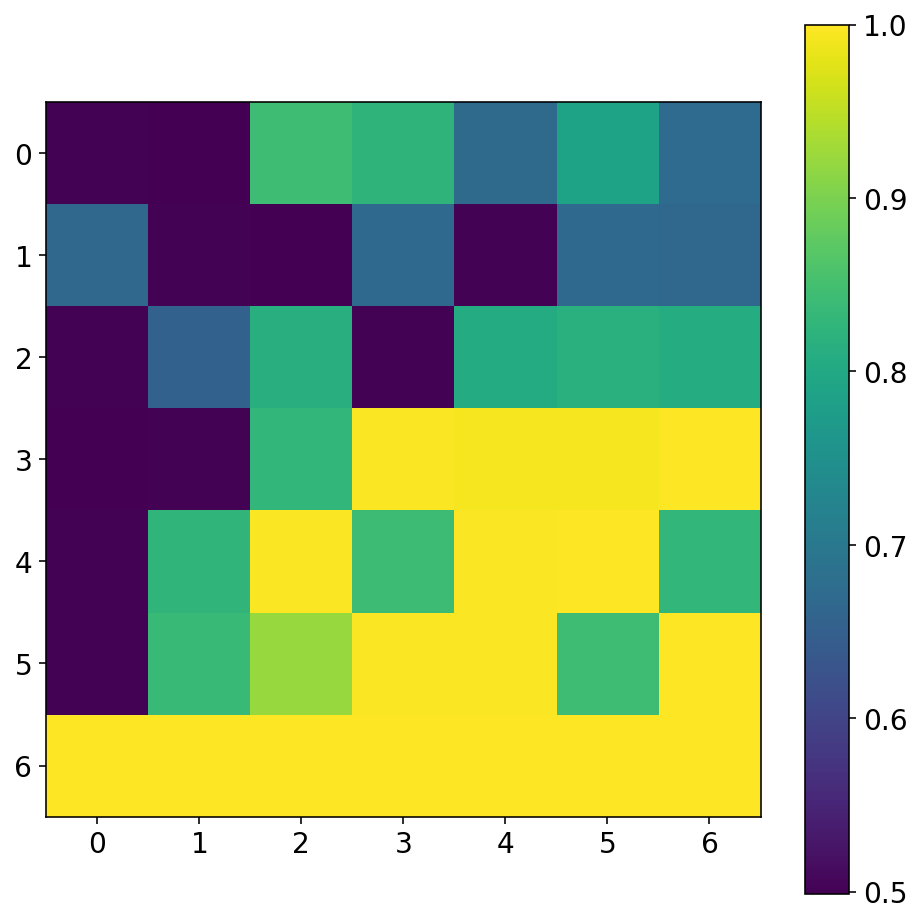

In [112]:
plt.imshow( scores, interpolation=None)
plt.colorbar()
print(scores)
#plt.savefig('images/two-layers_MLP_adam.png')


In [101]:
print(np.max(scores[(scores < 1.)]) )
print(scores)

0.9984375
[[ 0.5015625  0.4984375  0.8421875  0.8078125  0.6703125  0.8375     0.671875 ]
 [ 0.6671875  0.665625   0.5015625  0.5015625  0.4984375  0.653125   0.66875  ]
 [ 0.5015625  0.65625    0.8109375  0.5015625  0.8171875  0.8265625
   0.8109375]
 [ 0.5015625  0.4984375  0.6640625  0.9984375  0.9984375  0.8390625
   0.9984375]
 [ 0.5015625  0.846875   0.671875   0.43125    1.         0.8421875  1.       ]
 [ 0.5015625  1.         1.         1.         1.         1.         1.       ]
 [ 1.         1.         1.         1.         0.9984375  1.         1.       ]]


0.9984375


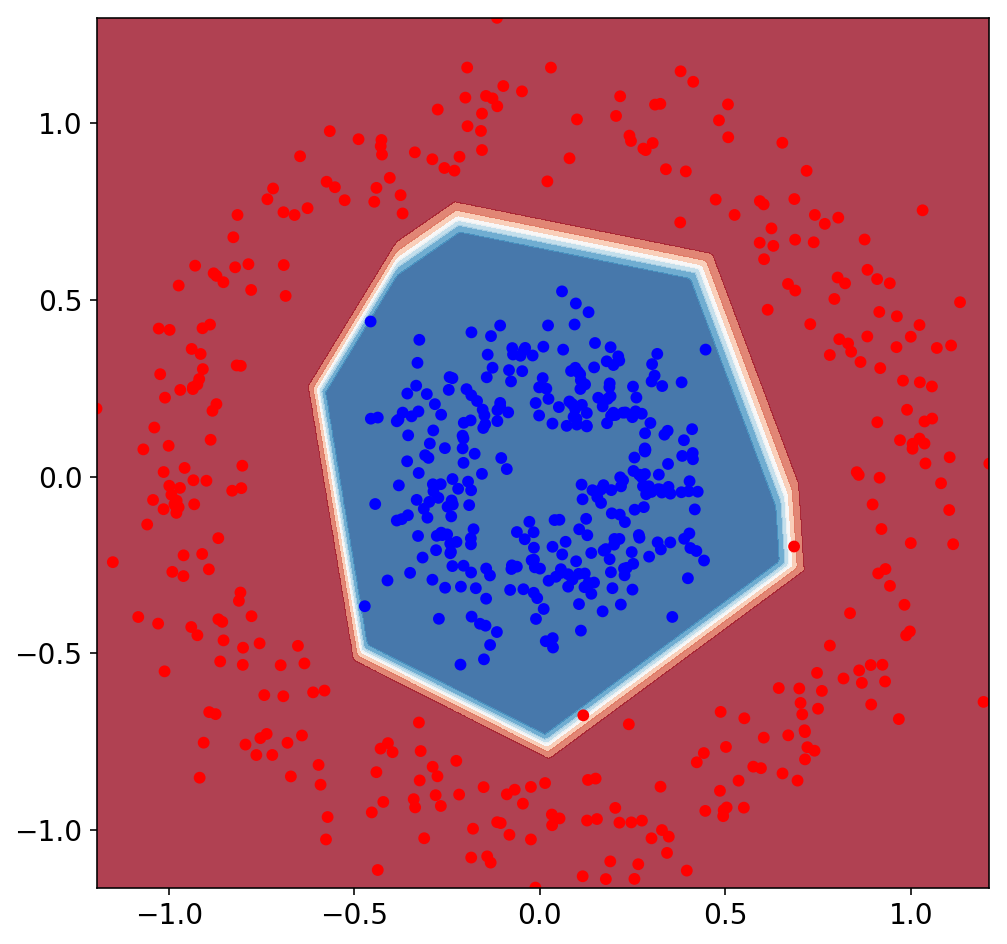

In [139]:
import utils
solver='adam'
#solver='sgd'
hidden_layer_sizes=(4,4,2)        
nnet = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, 
                         activation=activation, 
                         solver=solver,
                         alpha=alpha,
                         learning_rate_init=learning_rate_init,
                         max_iter=max_iter,
                         random_state=random_state)

nnet.fit(X_train,y_train)
utils.plot_surface(nnet, X_test, y_test,show=False)
#plt.savefig('images/single-layer-surface_adam.png')
print(nnet.score(X_test,y_test))

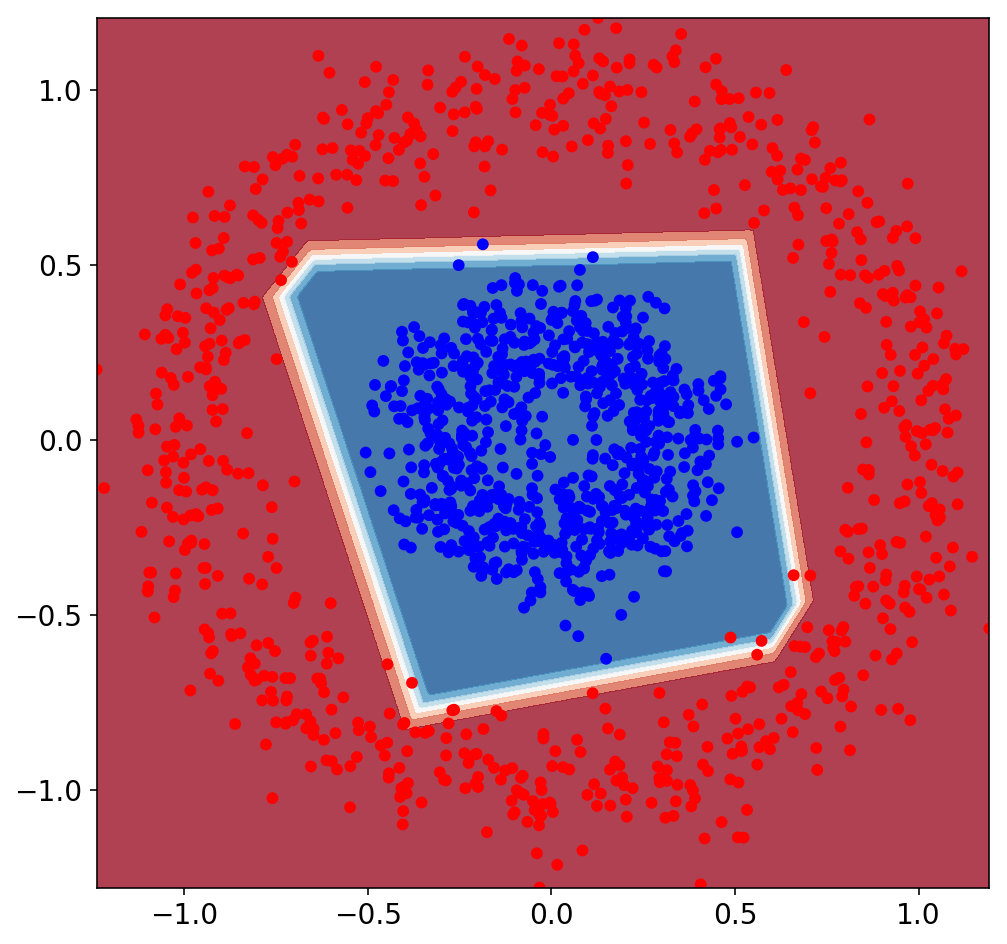

0.996875


In [116]:
import utils
hidden_layer_sizes=(4,4)        
nnet = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, 
                         activation=activation, 
                         solver=solver,
                         alpha=alpha,
                         learning_rate_init=learning_rate_init,
                         max_iter=max_iter,
                         random_state=random_state)

nnet.fit(X_train,y_train)
utils.plot_surface(nnet, X, y)
print(nnet.score(X_test,y_test))

## Polynomial features

let's replace $x,y$ with $x^2,y^2$

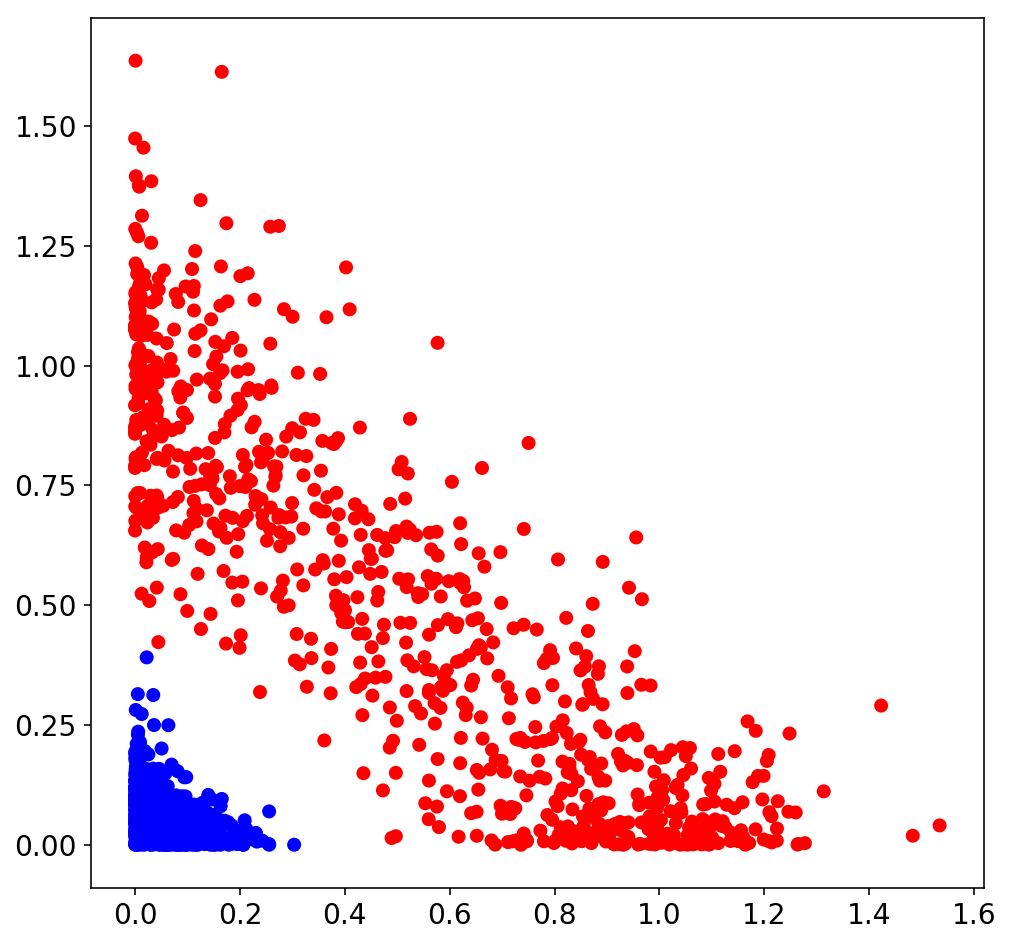

In [121]:
polyX = X**2
plt.scatter(polyX[:,0], polyX[:,1], c=y)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(polyX, y, train_size=0.6, random_state=42)

In [131]:
from sklearn.neural_network import MLPClassifier
scores = []

# ACTIVATION FUNCTION
activation='relu'

# SOLVER
#solver='adam'
solver='sgd'

# L2 REGULARIZATION PARAMETER
alpha=0.0001

# LEARNING RATE
#batch_size='auto'
#learning_rate='constant'
learning_rate_init=0.1
max_iter=500


# REPRODUCIBILITY
random_state = 42

layer_sizes = range(1,15)

for single_layer_size in layer_sizes:
    hidden_layer_sizes=(single_layer_size, )
    nnet = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, 
                     activation=activation, 
                     solver=solver,
                     alpha=alpha,
                     learning_rate_init=learning_rate_init,
                     max_iter=max_iter,
                     random_state=random_state)
    
    nnet.fit(X_train, y_train)
    scores.append( nnet.score(X_test,y_test) )

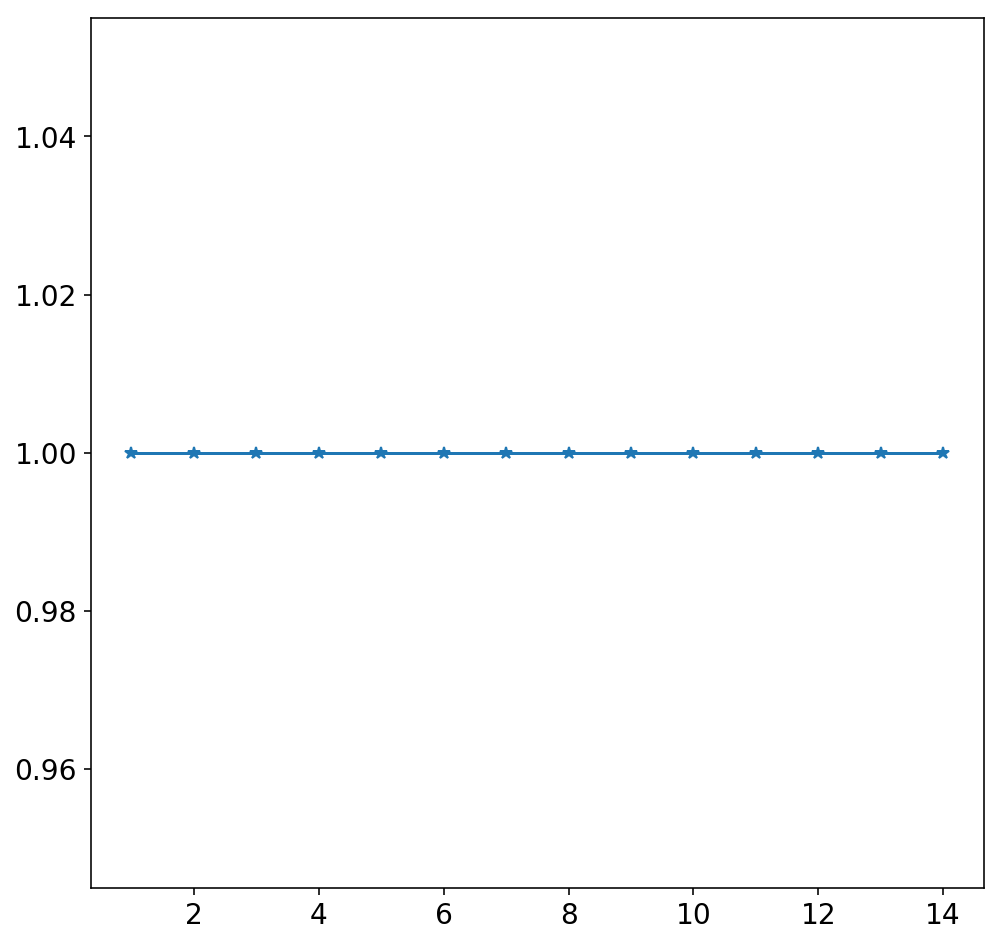

In [132]:
plt.plot(layer_sizes, scores, '-*')
      
plt.savefig('images/single_layer_MLP_poly.png')

1.0


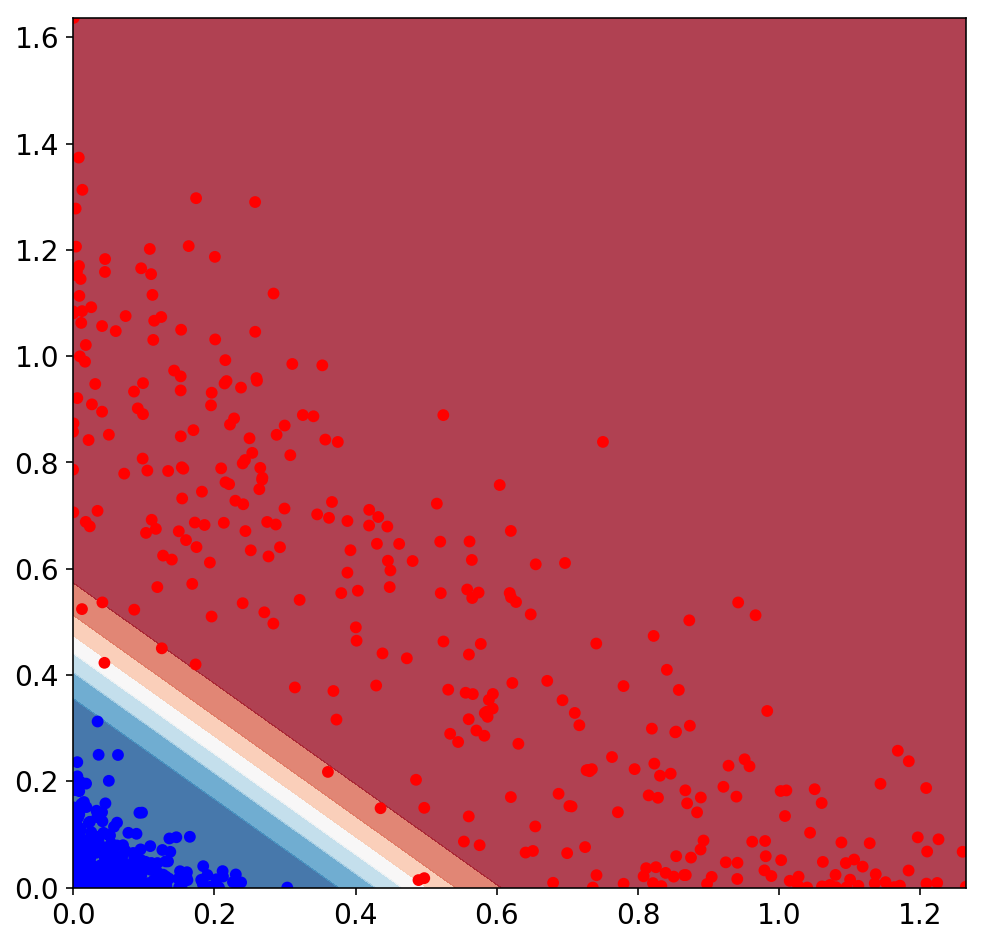

In [128]:
import utils
#solver='adam'
solver='sgd'
hidden_layer_sizes=(4,)        
nnet = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, 
                         activation=activation, 
                         solver=solver,
                         alpha=alpha,
                         learning_rate_init=learning_rate_init,
                         max_iter=max_iter,
                         random_state=random_state)

nnet.fit(X_train,y_train)
utils.plot_surface(nnet, X_test, y_test,show=False)
#plt.savefig('images/single-layer-surface_adam.png')
print(nnet.score(X_test,y_test))

In [133]:
from sklearn.neural_network import MLPClassifier

# ACTIVATION FUNCTION
activation='relu'

# SOLVER
#solver='adam'
solver='sgd'

# L2 REGULARIZATION PARAMETER
alpha=0.0001

# LEARNING RATE
#batch_size='auto'
#learning_rate='constant'
learning_rate_init=0.1
max_iter=500


# REPRODUCIBILITY
random_state = 42

layer_sizes = range(1,8)
scores = np.zeros(shape=(len(layer_sizes), len(layer_sizes)))

for i,single_layer_size_i in enumerate(layer_sizes):
    for j,single_layer_size_j in enumerate(layer_sizes):
        hidden_layer_sizes=(single_layer_size_i,single_layer_size_j)
        nnet = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, 
                         activation=activation, 
                         solver=solver,
                         alpha=alpha,
                         learning_rate_init=learning_rate_init,
                         max_iter=max_iter,
                         random_state=random_state)

        nnet.fit(X_train, y_train)
        scores[i][j] = nnet.score(X_test,y_test)


[[ 0.5015625  0.4984375  1.         1.         1.         1.         1.       ]
 [ 1.         1.         0.5015625  1.         0.4984375  1.         1.       ]
 [ 1.         1.         1.         0.5015625  0.9984375  1.         1.       ]
 [ 0.5015625  0.4984375  0.4984375  1.         1.         1.         1.       ]
 [ 0.5015625  1.         0.4984375  1.         1.         1.         1.       ]
 [ 0.5015625  1.         1.         1.         1.         1.         1.       ]
 [ 1.         1.         1.         1.         1.         1.         1.       ]]


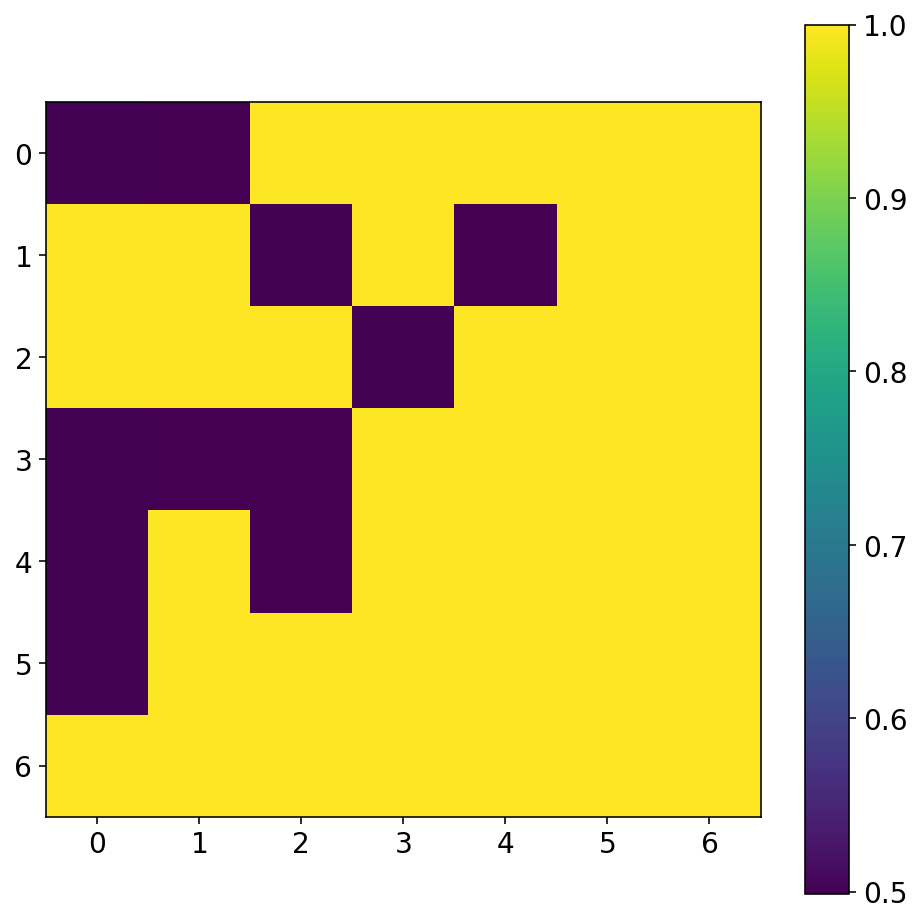

In [134]:
plt.imshow( scores, interpolation=None)
plt.colorbar()
print(scores)
plt.savefig('images/two-layers_MLP_poly.png')


## Visualize how NNs distort the space

To be able to do this, I'm going to create a network that satisfies the following two properties:
- gets good accuracy;
- last layer has only 2 neurons.

In this way, I'll be able to easily visualize how the input to an MLP is transformed into an output, just before classification.

NOTE: I'll go back to using the original features, since the polynomial features make this problem trivial.

0.9984375


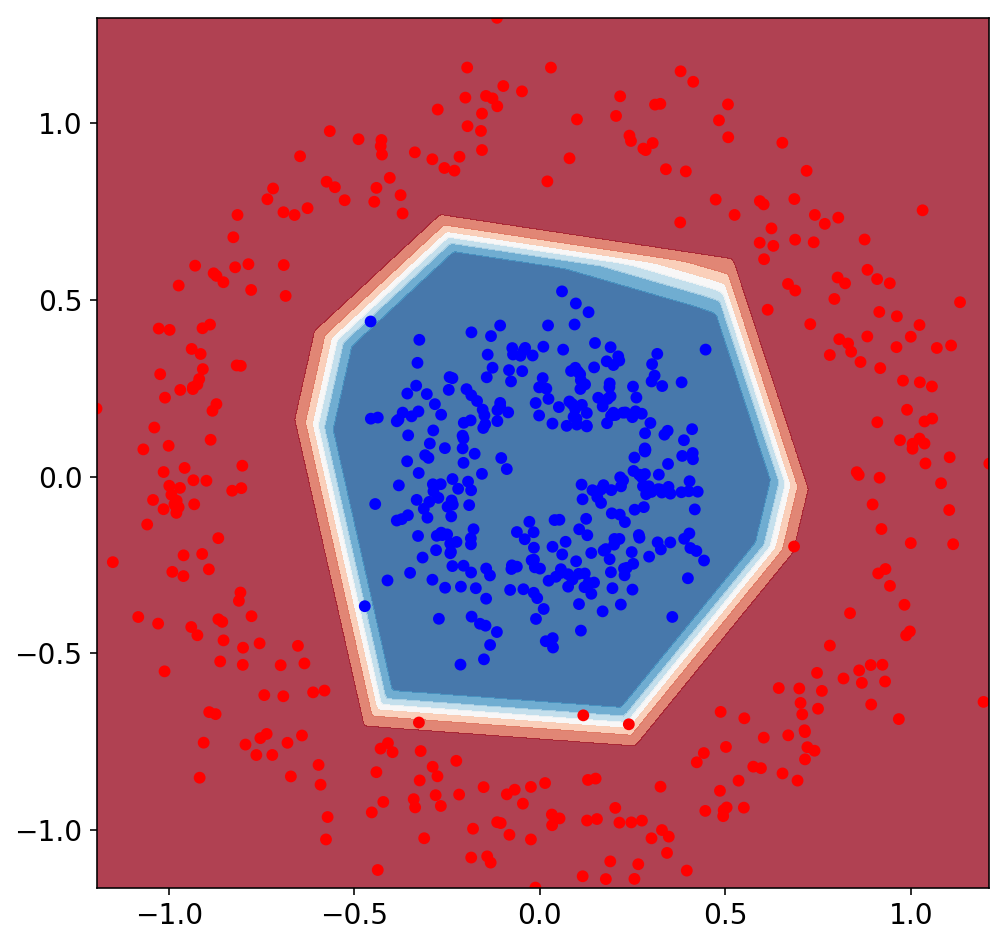

In [250]:
import utils
#solver='adam'
solver='sgd'
activation='relu'
hidden_layer_sizes=(4,4,2)        
nnet = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, 
                         activation=activation, 
                         solver=solver,
                         alpha=alpha,
                         learning_rate_init=learning_rate_init,
                         max_iter=max_iter,
                         random_state=random_state)

nnet.fit(X_train,y_train)
utils.plot_surface(nnet, X_test, y_test,show=False)
#plt.savefig('images/single-layer-surface_adam.png')
print(nnet.score(X_test,y_test))

In [251]:
Ws = nnet.coefs_
biases = nnet.intercepts_

distorted_X = np.zeros_like(X_test)

def my_relu(x):
    return x*(x > 0.)

# Visualize second-last layer
for i,x in enumerate(X_test):
    distorted_x = x
    for w,b in zip(Ws[:-2],biases[:-2]):
        distorted_x = np.dot(distorted_x,w)
        distorted_x = my_relu(distorted_x + b)
    distorted_x = np.dot(distorted_x,Ws[-2])
    distorted_X[i,:] = distorted_x

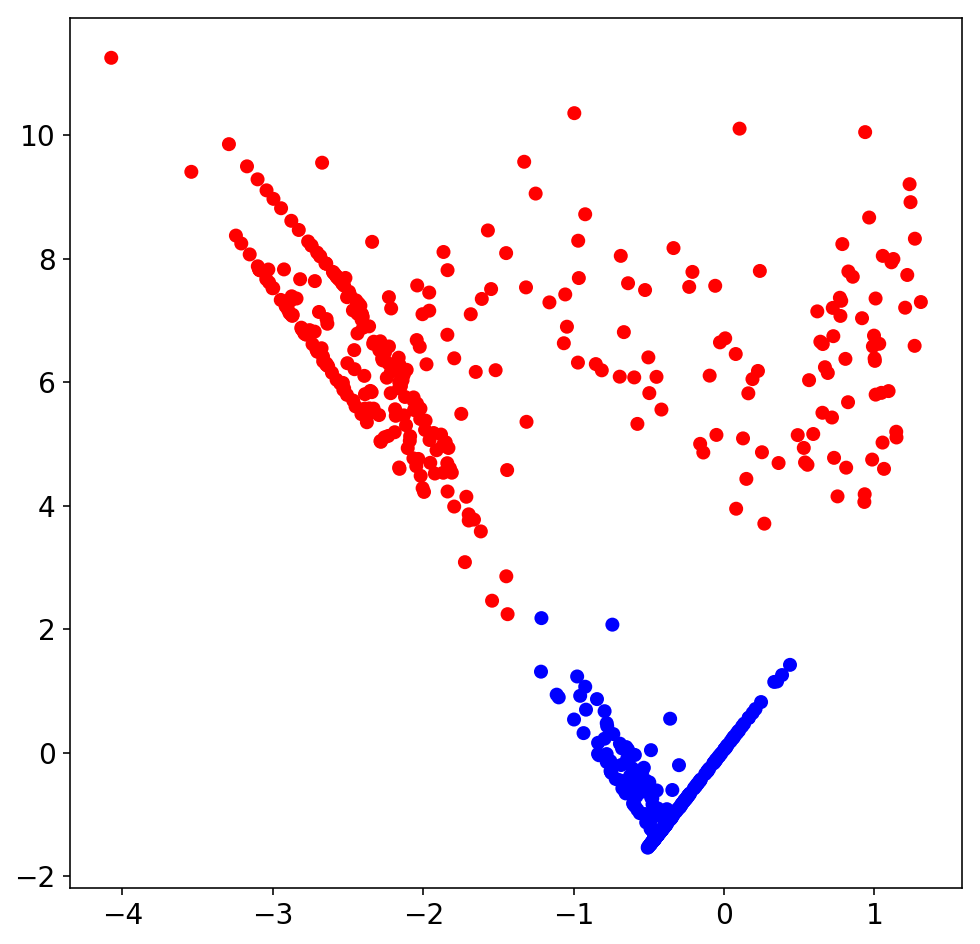

In [252]:
plt.scatter(distorted_X[:,0],distorted_X[:,1],c=y_test)
plt.savefig("images/distorted_without_final_relu.png")

0.996875


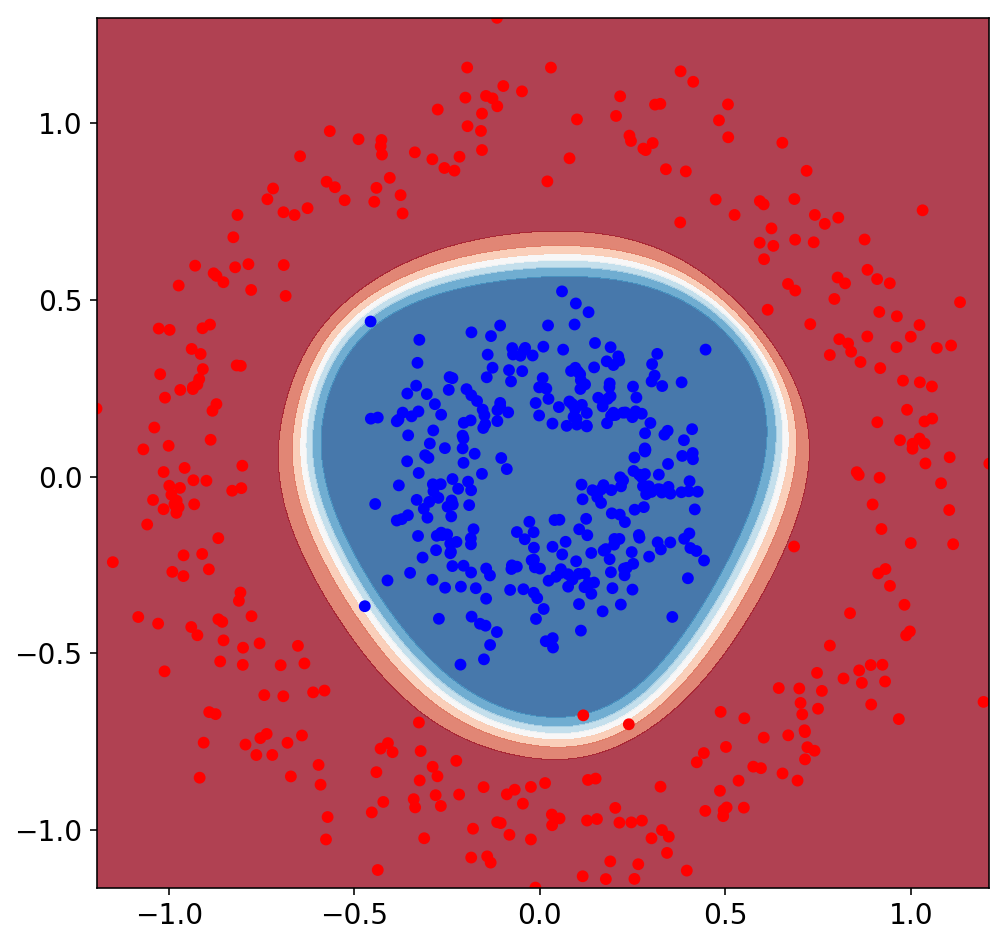

In [256]:
import utils
#solver='adam'
solver='sgd'
activation='tanh'
hidden_layer_sizes=(3,2)        
nnet = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, 
                         activation=activation, 
                         solver=solver,
                         alpha=alpha,
                         learning_rate_init=learning_rate_init,
                         max_iter=max_iter,
                         random_state=random_state)

nnet.fit(X_train,y_train)
utils.plot_surface(nnet, X_test, y_test,show=False)
plt.savefig("images/tanh-surface.png")
print(nnet.score(X_test,y_test))

In [254]:
Ws = nnet.coefs_
biases = nnet.intercepts_

distorted_X = np.zeros_like(X_test)

# Visualize second-last layer
for i,x in enumerate(X_test):
    distorted_x = x
    for w,b in zip(Ws[:-2],biases[:-2]):
        distorted_x = np.dot(distorted_x,w)
        distorted_x = np.tanh(distorted_x + b)
    distorted_x = np.dot(distorted_x,Ws[-2])
    distorted_X[i,:] = distorted_x

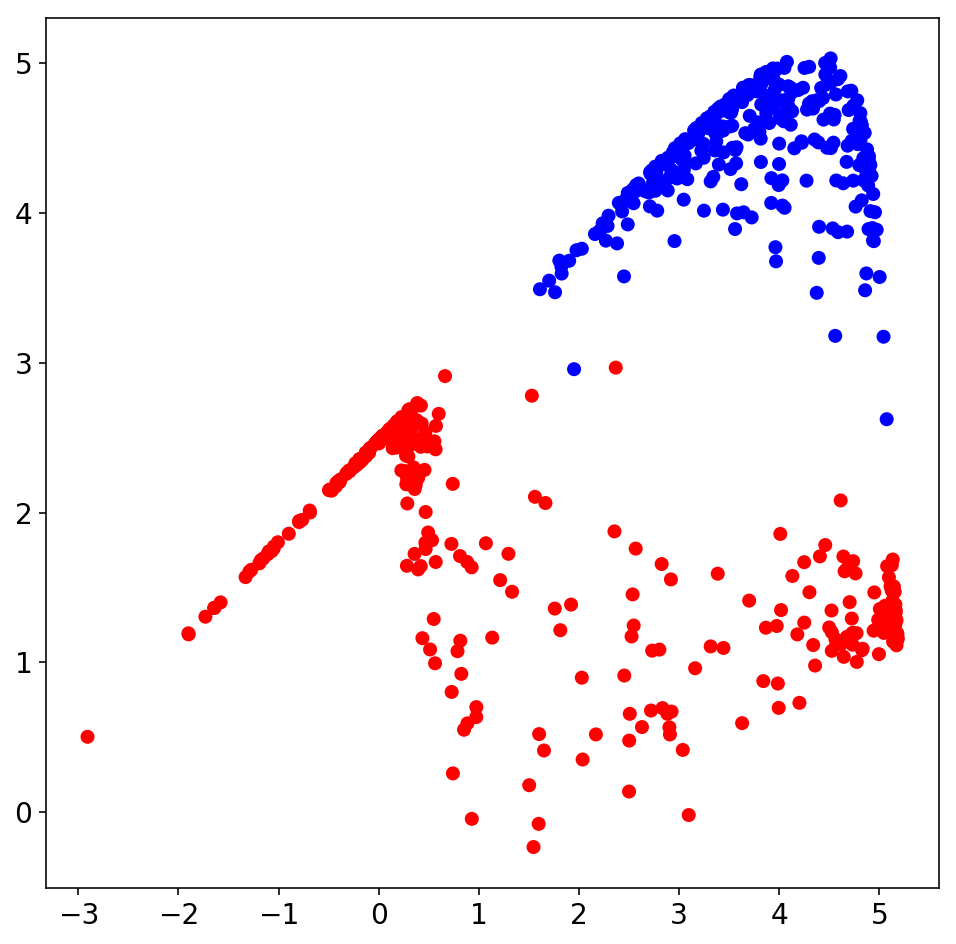

In [255]:
plt.scatter(distorted_X[:,0],distorted_X[:,1],c=y_test)
plt.savefig("images/distorted_without_final_relu_tanh.png")

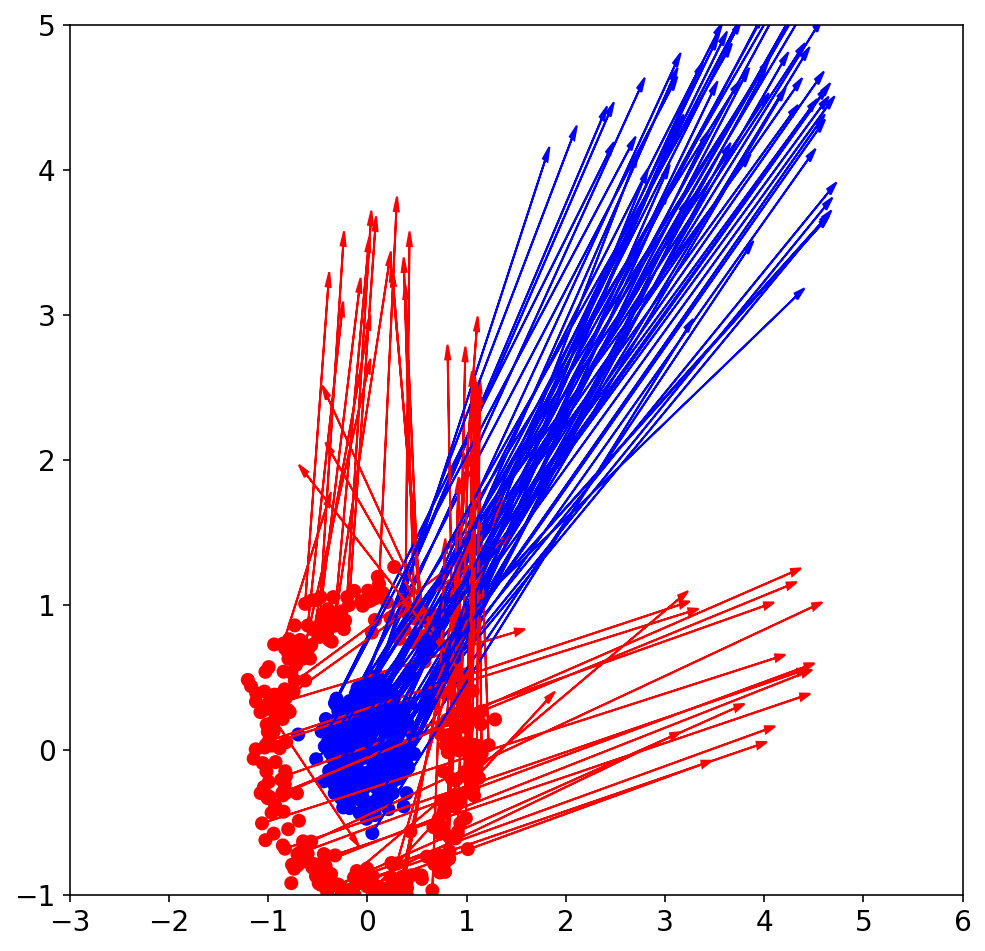

In [281]:
Ws = nnet.coefs_
biases = nnet.intercepts_

#xx = np.arange(start = X[:,0].min(), stop = X[:,0].max(), step = 0.2 )
#yy = np.arange(start = X[:,1].min(), stop = X[:,1].max(), step = 0.2 )

fig,ax = plt.subplots()
ax.set_xlim([-3.,6.])
ax.set_ylim([-1.,5.])

#for i,x in enumerate(xx):
#    for j,y in enumerate(yy):
for i,x in enumerate(X_test[::5,:]):
    distorted_x = x
#    distorted_x = np.array([x,y])
    for w,b in zip(Ws[:-2],biases[:-2]):
        distorted_x = np.dot(distorted_x,w)
        distorted_x = np.tanh(distorted_x + b)
    distorted_x = np.dot(distorted_x,Ws[-2])
    color = nnet.predict(np.array(x).reshape(1, -1))
    #print(color)
    ax.arrow(x[0],x[1],distorted_x[0],distorted_x[1],head_width=0.05, head_length=0.1, fc=color[0], ec=color[0])

ax.scatter(X_test[:,0],X_test[:,1],c=y_test) 
plt.savefig('images/space_distortion_arrows.png')


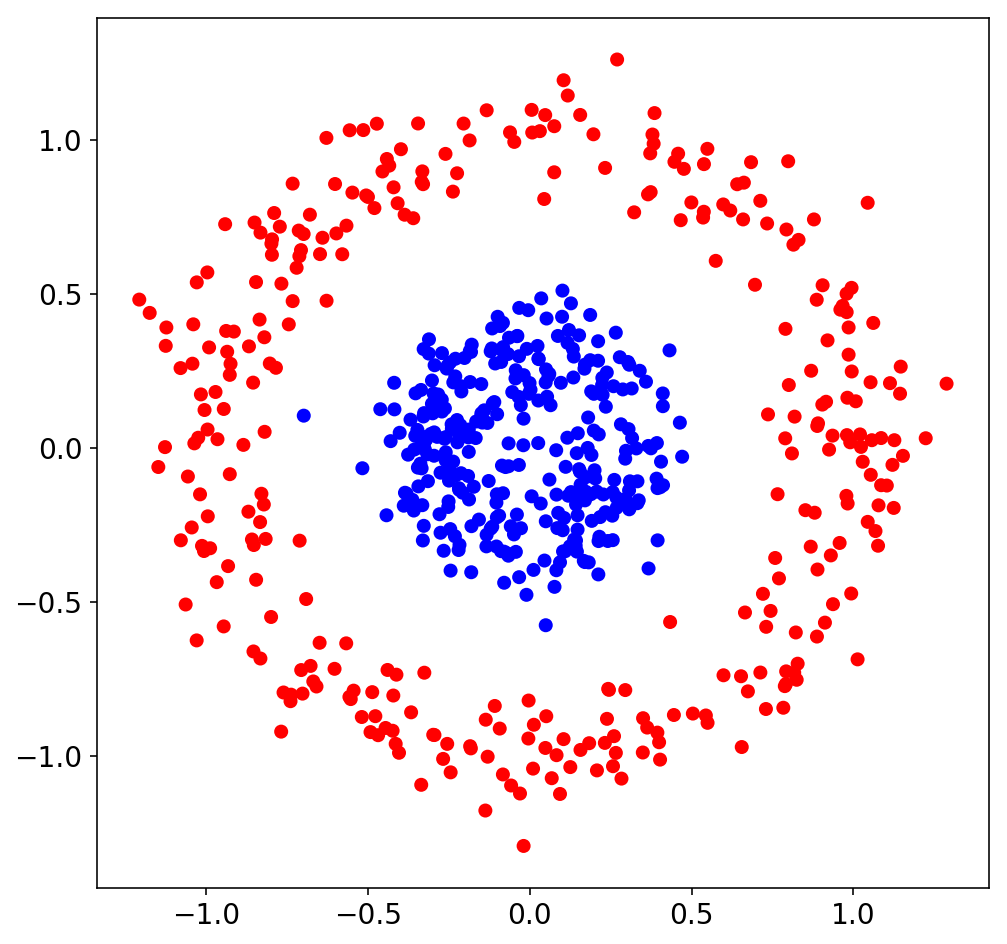

In [268]:
plt.scatter(X_test[:,0],X_test[:,1],c=y_test)

---

## Question 2.5

Use the spiral data set build a neural network classifier that can solve the problem (scikit-learn provides a MLPClassifier classifier that implements a neural network). Comment on:
* what is the minimum number of layers
* what is the minimum width of each layer
* is there a difference between using the tanh and ReLU activation functions?
* (bonus) build the same neural network using `keras` instead.
* (bonus) can you create a visualisation to show how the network transforms the problem? (Tim isn't sure this can be done, so don't spend forever on this.)

## Summary of results

### Discussion

I will refer to the table below. I am quite surprised by two things:
- a single-layer with 4 tanh neurons is able to achieve 91%. Similarly, a single layer with 7 relu neurons achieves 95% accuracy.
- adding layers doesn't seem to help much, in the sense that the networks able to achieve the best tradeoff between number of parameters to train and accuracy seem to be the single-layer ones.

### Raw results

Here is a giant table with my grid search results

|solver|activation|layers|score|
|--|--|--|:--:|
| adam| tanh| (4,)| 0.916666666667| 
| adam| tanh| (7,)| 0.983333333333| 
| adam| tanh| (10,)| 0.979166666667| 
| adam| tanh| (15,)| 0.5375| 
| adam| tanh| (20,)| 0.533333333333| 
| adam| relu| (4,)| 0.579166666667| 
| adam| relu| (7,)| 0.983333333333| 
| adam| relu| (10,)| 0.991666666667| 
| adam| relu| (15,)| 0.979166666667| 
| adam| relu| (20,)| 0.925| 
| sgd| tanh| (4,)| 0.754166666667| 
| sgd| tanh| (7,)| 0.954166666667| 
| sgd| tanh| (10,)| 0.9625| 
| sgd| tanh| (15,)| 0.966666666667| 
| sgd| tanh| (20,)| 0.525| 
| sgd| relu| (4,)| 0.529166666667| 
| sgd| relu| (7,)| 0.866666666667\*| 
| sgd| relu| (10,)| 0.975| 
| sgd| relu| (15,)| 0.9375| 
| sgd| relu| (20,)| 0.858333333333| 
| adam| tanh| (4, 4)| 0.975| 
| adam| tanh| (4, 7)| 0.991666666667| 
| adam| tanh| (4, 10)| 0.983333333333| 
| adam| tanh| (4, 15)| 0.979166666667| 
| adam| tanh| (4, 20)| 0.991666666667| 
| adam| tanh| (7, 4)| 0.975| 
| adam| tanh| (7, 7)| 0.975| 
| adam| tanh| (7, 10)| 0.9875| 
| adam| tanh| (7, 15)| 0.983333333333| 
| adam| tanh| (7, 20)| 0.541666666667| 
| adam| tanh| (10, 4)| 0.979166666667| 
| adam| tanh| (10, 7)| 0.9875| 
| adam| tanh| (10, 10)| 0.954166666667| 
| adam| tanh| (10, 15)| 0.9875| 
| adam| tanh| (10, 20)| 0.983333333333| 
| adam| tanh| (15, 4)| 0.983333333333| 
| adam| tanh| (15, 7)| 0.979166666667| 
| adam| tanh| (15, 10)| 0.983333333333| 
| adam| tanh| (15, 15)| 0.979166666667| 
| adam| tanh| (15, 20)| 0.983333333333| 
| adam| tanh| (20, 4)| 0.991666666667| 
| adam| tanh| (20, 7)| 0.975| 
| adam| tanh| (20, 10)| 0.983333333333| 
| adam| tanh| (20, 15)| 0.9875| 
| adam| tanh| (20, 20)| 0.991666666667| 
| adam| relu| (4, 4)| 0.729166666667| 
| adam| relu| (4, 7)| 0.775| 
| adam| relu| (4, 10)| 0.766666666667| 
| adam| relu| (4, 15)| 0.966666666667| 
| adam| relu| (4, 20)| 0.954166666667| 
| adam| relu| (7, 4)| 0.975| 
| adam| relu| (7, 7)| 0.991666666667| 
| adam| relu| (7, 10)| 0.9875| 
| adam| relu| (7, 15)| 0.991666666667| 
| adam| relu| (7, 20)| 0.991666666667| 
| adam| relu| (10, 4)| 0.883333333333| 
| adam| relu| (10, 7)| 0.983333333333| 
| adam| relu| (10, 10)| 0.983333333333| 
| adam| relu| (10, 15)| 0.983333333333| 
| adam| relu| (10, 20)| 0.991666666667| 
| adam| relu| (15, 4)| 0.545833333333| 
| adam| relu| (15, 7)| 0.979166666667| 
| adam| relu| (15, 10)| 0.970833333333| 
| adam| relu| (15, 15)| 0.983333333333| 
| adam| relu| (15, 20)| 0.975| 
| adam| relu| (20, 4)| 0.991666666667| 
| adam| relu| (20, 7)| 0.991666666667| 
| adam| relu| (20, 10)| 0.9875| 
| adam| relu| (20, 15)| 0.983333333333| 
| adam| relu| (20, 20)| 0.995833333333| 
| sgd| tanh| (4, 4)| 0.945833333333| 
| sgd| tanh| (4, 7)| 0.945833333333| 
| sgd| tanh| (4, 10)| 0.766666666667| 
| sgd| tanh| (4, 15)| 0.9625| 
| sgd| tanh| (4, 20)| 0.945833333333| 
| sgd| tanh| (7, 4)| 0.966666666667| 
| sgd| tanh| (7, 7)| 0.975| 
| sgd| tanh| (7, 10)| 0.958333333333| 
| sgd| tanh| (7, 15)| 0.975| 
| sgd| tanh| (7, 20)| 0.975| 
| sgd| tanh| (10, 4)| 0.966666666667| 
| sgd| tanh| (10, 7)| 0.983333333333| 
| sgd| tanh| (10, 10)| 0.975| 
| sgd| tanh| (10, 15)| 0.983333333333| 
| sgd| tanh| (10, 20)| 0.975| 
| sgd| tanh| (15, 4)| 0.975| 
| sgd| tanh| (15, 7)| 0.991666666667| 
| sgd| tanh| (15, 10)| 0.975| 
| sgd| tanh| (15, 15)| 0.975| 
| sgd| tanh| (15, 20)| 0.975| 
| sgd| tanh| (20, 4)| 0.8375| 
| sgd| tanh| (20, 7)| 0.979166666667| 
| sgd| tanh| (20, 10)| 0.979166666667| 
| sgd| tanh| (20, 15)| 0.983333333333| 
| sgd| tanh| (20, 20)| 0.975| 
| sgd| relu| (4, 4)| 0.716666666667| 
| sgd| relu| (4, 7)| 0.891666666667| 
| sgd| relu| (4, 10)| 0.766666666667| 
| sgd| relu| (4, 15)| 0.8875| 
| sgd| relu| (4, 20)| 0.775| 
| sgd| relu| (7, 4)| 0.970833333333| 
| sgd| relu| (7, 7)| 0.966666666667| 
| sgd| relu| (7, 10)| 0.983333333333| 
| sgd| relu| (7, 15)| 0.983333333333| 
| sgd| relu| (7, 20)| 0.979166666667| 
| sgd| relu| (10, 4)| 0.816666666667| 
| sgd| relu| (10, 7)| 0.983333333333| 
| sgd| relu| (10, 10)| 0.941666666667| 
| sgd| relu| (10, 15)| 0.966666666667| 
| sgd| relu| (10, 20)| 0.954166666667| 
| sgd| relu| (15, 4)| 0.316666666667| 
| sgd| relu| (15, 7)| 0.958333333333| 
| sgd| relu| (15, 10)| 0.9| 
| sgd| relu| (15, 15)| 0.95| 
| sgd| relu| (15, 20)| 0.966666666667| 
| sgd| relu| (20, 4)| 0.941666666667| 
| sgd| relu| (20, 7)| 0.929166666667| 
| sgd| relu| (20, 10)| 0.95| 
| sgd| relu| (20, 15)| 0.941666666667| 
| sgd| relu| (20, 20)| 0.970833333333| 
| adam| tanh| (4, 4, 4)| 0.983333333333| 
| adam| tanh| (4, 4, 7)| 0.975| 
| adam| tanh| (4, 4, 10)| 0.958333333333| 
| adam| tanh| (4, 4, 15)| 0.966666666667| 
| adam| tanh| (4, 4, 20)| 0.983333333333| 
| adam| tanh| (4, 7, 4)| 0.991666666667| 
| adam| tanh| (4, 7, 7)| 0.979166666667| 
| adam| tanh| (4, 7, 10)| 0.9875| 
| adam| tanh| (4, 7, 15)| 0.991666666667| 
| adam| tanh| (4, 7, 20)| 0.9875| 
| adam| tanh| (4, 10, 4)| 0.979166666667| 
| adam| tanh| (4, 10, 7)| 0.958333333333| 
| adam| tanh| (4, 10, 10)| 0.979166666667| 
| adam| tanh| (4, 10, 15)| 0.979166666667| 
| adam| tanh| (4, 10, 20)| 0.991666666667| 
| adam| tanh| (4, 15, 4)| 0.966666666667| 
| adam| tanh| (4, 15, 7)| 0.983333333333| 
| adam| tanh| (4, 15, 10)| 0.9875| 
| adam| tanh| (4, 15, 15)| 0.95| 
| adam| tanh| (4, 15, 20)| 0.983333333333| 
| adam| tanh| (4, 20, 4)| 0.933333333333| 
| adam| tanh| (4, 20, 7)| 0.9625| 
| adam| tanh| (4, 20, 10)| 0.979166666667| 
| adam| tanh| (4, 20, 15)| 0.979166666667| 
| adam| tanh| (4, 20, 20)| 0.966666666667| 
| adam| tanh| (7, 4, 4)| 0.983333333333| 
| adam| tanh| (7, 4, 7)| 0.9625| 
| adam| tanh| (7, 4, 10)| 0.970833333333| 
| adam| tanh| (7, 4, 15)| 0.954166666667| 
| adam| tanh| (7, 4, 20)| 0.975| 
| adam| tanh| (7, 7, 4)| 0.983333333333| 
| adam| tanh| (7, 7, 7)| 0.975| 
| adam| tanh| (7, 7, 10)| 0.983333333333| 
| adam| tanh| (7, 7, 15)| 0.970833333333| 
| adam| tanh| (7, 7, 20)| 0.991666666667| 
| adam| tanh| (7, 10, 4)| 0.983333333333| 
| adam| tanh| (7, 10, 7)| 0.966666666667| 
| adam| tanh| (7, 10, 10)| 0.991666666667| 
| adam| tanh| (7, 10, 15)| 0.983333333333| 
| adam| tanh| (7, 10, 20)| 0.983333333333| 
| adam| tanh| (7, 15, 4)| 0.9875| 
| adam| tanh| (7, 15, 7)| 0.9875| 
| adam| tanh| (7, 15, 10)| 0.991666666667| 
| adam| tanh| (7, 15, 15)| 0.983333333333| 
| adam| tanh| (7, 15, 20)| 0.9875| 
| adam| tanh| (7, 20, 4)| 0.983333333333| 
| adam| tanh| (7, 20, 7)| 0.983333333333| 
| adam| tanh| (7, 20, 10)| 0.979166666667| 
| adam| tanh| (7, 20, 15)| 0.995833333333| 
| adam| tanh| (7, 20, 20)| 0.991666666667| 
| adam| tanh| (10, 4, 4)| 0.858333333333| 
| adam| tanh| (10, 4, 7)| 0.995833333333| 
| adam| tanh| (10, 4, 10)| 0.983333333333| 
| adam| tanh| (10, 4, 15)| 0.983333333333| 
| adam| tanh| (10, 4, 20)| 0.983333333333| 
| adam| tanh| (10, 7, 4)| 0.979166666667| 
| adam| tanh| (10, 7, 7)| 0.979166666667| 
| adam| tanh| (10, 7, 10)| 0.975| 
| adam| tanh| (10, 7, 15)| 0.991666666667| 
| adam| tanh| (10, 7, 20)| 0.9875| 
| adam| tanh| (10, 10, 4)| 0.9875| 
| adam| tanh| (10, 10, 7)| 0.991666666667| 
| adam| tanh| (10, 10, 10)| 0.970833333333| 
| adam| tanh| (10, 10, 15)| 0.983333333333| 
| adam| tanh| (10, 10, 20)| 0.9875| 
| adam| tanh| (10, 15, 4)| 0.979166666667| 
| adam| tanh| (10, 15, 7)| 0.983333333333| 
| adam| tanh| (10, 15, 10)| 0.979166666667| 
| adam| tanh| (10, 15, 15)| 0.995833333333| 
| adam| tanh| (10, 15, 20)| 0.979166666667| 
| adam| tanh| (10, 20, 4)| 0.991666666667| 
| adam| tanh| (10, 20, 7)| 0.9875| 
| adam| tanh| (10, 20, 10)| 0.979166666667| 
| adam| tanh| (10, 20, 15)| 0.983333333333| 
| adam| tanh| (10, 20, 20)| 0.9875| 
| adam| tanh| (15, 4, 4)| 0.904166666667| 
| adam| tanh| (15, 4, 7)| 0.9875| 
| adam| tanh| (15, 4, 10)| 0.966666666667| 
| adam| tanh| (15, 4, 15)| 0.983333333333| 
| adam| tanh| (15, 4, 20)| 0.983333333333| 
| adam| tanh| (15, 7, 4)| 0.9875| 
| adam| tanh| (15, 7, 7)| 0.9625| 
| adam| tanh| (15, 7, 10)| 0.979166666667| 
| adam| tanh| (15, 7, 15)| 0.975| 
| adam| tanh| (15, 7, 20)| 0.983333333333| 
| adam| tanh| (15, 10, 4)| 0.975| 
| adam| tanh| (15, 10, 7)| 0.9875| 
| adam| tanh| (15, 10, 10)| 0.9875| 
| adam| tanh| (15, 10, 15)| 0.9875| 
| adam| tanh| (15, 10, 20)| 0.979166666667| 
| adam| tanh| (15, 15, 4)| 0.983333333333| 
| adam| tanh| (15, 15, 7)| 0.979166666667| 
| adam| tanh| (15, 15, 10)| 0.9875| 
| adam| tanh| (15, 15, 15)| 0.966666666667| 
| adam| tanh| (15, 15, 20)| 0.983333333333| 
| adam| tanh| (15, 20, 4)| 0.991666666667| 
| adam| tanh| (15, 20, 7)| 0.991666666667| 
| adam| tanh| (15, 20, 10)| 0.983333333333| 
| adam| tanh| (15, 20, 15)| 0.991666666667| 
| adam| tanh| (15, 20, 20)| 0.979166666667| 
| adam| tanh| (20, 4, 4)| 0.975| 
| adam| tanh| (20, 4, 7)| 0.9875| 
| adam| tanh| (20, 4, 10)| 0.945833333333| 
| adam| tanh| (20, 4, 15)| 0.958333333333| 
| adam| tanh| (20, 4, 20)| 0.8125| 
| adam| tanh| (20, 7, 4)| 0.975| 
| adam| tanh| (20, 7, 7)| 0.983333333333| 
| adam| tanh| (20, 7, 10)| 0.983333333333| 
| adam| tanh| (20, 7, 15)| 0.979166666667| 
| adam| tanh| (20, 7, 20)| 0.983333333333| 
| adam| tanh| (20, 10, 4)| 0.9875| 
| adam| tanh| (20, 10, 7)| 0.9875| 
| adam| tanh| (20, 10, 10)| 0.983333333333| 
| adam| tanh| (20, 10, 15)| 0.904166666667| 
| adam| tanh| (20, 10, 20)| 0.983333333333| 
| adam| tanh| (20, 15, 4)| 0.983333333333| 
| adam| tanh| (20, 15, 7)| 0.9875| 
| adam| tanh| (20, 15, 10)| 0.983333333333| 
| adam| tanh| (20, 15, 15)| 0.983333333333| 
| adam| tanh| (20, 15, 20)| 0.983333333333| 
| adam| tanh| (20, 20, 4)| 0.966666666667| 
| adam| tanh| (20, 20, 7)| 0.983333333333| 
| adam| tanh| (20, 20, 10)| 0.991666666667| 
| adam| tanh| (20, 20, 15)| 0.979166666667| 
| adam| tanh| (20, 20, 20)| 0.966666666667| 
| adam| relu| (4, 4, 4)| 0.345833333333| 
| adam| relu| (4, 4, 7)| 0.7625| 
| adam| relu| (4, 4, 10)| 0.795833333333| 
| adam| relu| (4, 4, 15)| 0.766666666667| 
| adam| relu| (4, 4, 20)| 0.895833333333| 
| adam| relu| (4, 7, 4)| 0.783333333333| 
| adam| relu| (4, 7, 7)| 0.754166666667| 
| adam| relu| (4, 7, 10)| 0.979166666667| 
| adam| relu| (4, 7, 15)| 0.979166666667| 
| adam| relu| (4, 7, 20)| 0.983333333333| 
| adam| relu| (4, 10, 4)| 0.616666666667| 
| adam| relu| (4, 10, 7)| 0.941666666667| 
| adam| relu| (4, 10, 10)| 0.9625| 
| adam| relu| (4, 10, 15)| 0.754166666667| 
| adam| relu| (4, 10, 20)| 0.883333333333| 
| adam| relu| (4, 15, 4)| 0.929166666667| 
| adam| relu| (4, 15, 7)| 0.970833333333| 
| adam| relu| (4, 15, 10)| 0.945833333333| 
| adam| relu| (4, 15, 15)| 0.908333333333| 
| adam| relu| (4, 15, 20)| 0.9625| 
| adam| relu| (4, 20, 4)| 0.9875| 
| adam| relu| (4, 20, 7)| 0.833333333333| 
| adam| relu| (4, 20, 10)| 0.9875| 
| adam| relu| (4, 20, 15)| 0.729166666667| 
| adam| relu| (4, 20, 20)| 0.983333333333| 
| adam| relu| (7, 4, 4)| 0.9| 
| adam| relu| (7, 4, 7)| 0.979166666667| 
| adam| relu| (7, 4, 10)| 0.970833333333| 
| adam| relu| (7, 4, 15)| 0.9875| 
| adam| relu| (7, 4, 20)| 0.945833333333| 
| adam| relu| (7, 7, 4)| 0.3375| 
| adam| relu| (7, 7, 7)| 0.8875| 
| adam| relu| (7, 7, 10)| 0.975| 
| adam| relu| (7, 7, 15)| 0.9875| 
| adam| relu| (7, 7, 20)| 0.9875| 
| adam| relu| (7, 10, 4)| 0.95| 
| adam| relu| (7, 10, 7)| 0.8875| 
| adam| relu| (7, 10, 10)| 0.970833333333| 
| adam| relu| (7, 10, 15)| 0.983333333333| 
| adam| relu| (7, 10, 20)| 0.9875| 
| adam| relu| (7, 15, 4)| 0.983333333333| 
| adam| relu| (7, 15, 7)| 0.991666666667| 
| adam| relu| (7, 15, 10)| 0.895833333333| 
| adam| relu| (7, 15, 15)| 0.983333333333| 
| adam| relu| (7, 15, 20)| 0.995833333333| 
| adam| relu| (7, 20, 4)| 0.95| 
| adam| relu| (7, 20, 7)| 0.875| 
| adam| relu| (7, 20, 10)| 0.991666666667| 
| adam| relu| (7, 20, 15)| 0.970833333333| 
| adam| relu| (7, 20, 20)| 0.983333333333| 
| adam| relu| (10, 4, 4)| 0.695833333333| 
| adam| relu| (10, 4, 7)| 0.945833333333| 
| adam| relu| (10, 4, 10)| 0.704166666667| 
| adam| relu| (10, 4, 15)| 0.720833333333| 
| adam| relu| (10, 4, 20)| 0.991666666667| 
| adam| relu| (10, 7, 4)| 0.941666666667| 
| adam| relu| (10, 7, 7)| 0.991666666667| 
| adam| relu| (10, 7, 10)| 0.983333333333| 
| adam| relu| (10, 7, 15)| 0.941666666667| 
| adam| relu| (10, 7, 20)| 0.991666666667| 
| adam| relu| (10, 10, 4)| 0.991666666667| 
| adam| relu| (10, 10, 7)| 0.979166666667| 
| adam| relu| (10, 10, 10)| 0.9875| 
| adam| relu| (10, 10, 15)| 0.983333333333| 
| adam| relu| (10, 10, 20)| 0.983333333333| 
| adam| relu| (10, 15, 4)| 0.975| 
| adam| relu| (10, 15, 7)| 0.9625| 
| adam| relu| (10, 15, 10)| 0.95| 
| adam| relu| (10, 15, 15)| 0.954166666667| 
| adam| relu| (10, 15, 20)| 0.9875| 
| adam| relu| (10, 20, 4)| 0.895833333333| 
| adam| relu| (10, 20, 7)| 0.9875| 
| adam| relu| (10, 20, 10)| 0.983333333333| 
| adam| relu| (10, 20, 15)| 0.979166666667| 
| adam| relu| (10, 20, 20)| 0.9875| 
| adam| relu| (15, 4, 4)| 0.891666666667| 
| adam| relu| (15, 4, 7)| 0.704166666667| 
| adam| relu| (15, 4, 10)| 0.929166666667| 
| adam| relu| (15, 4, 15)| 0.975| 
| adam| relu| (15, 4, 20)| 0.9375| 
| adam| relu| (15, 7, 4)| 0.983333333333| 
| adam| relu| (15, 7, 7)| 0.975| 
| adam| relu| (15, 7, 10)| 0.983333333333| 
| adam| relu| (15, 7, 15)| 0.983333333333| 
| adam| relu| (15, 7, 20)| 0.9625| 
| adam| relu| (15, 10, 4)| 0.941666666667| 
| adam| relu| (15, 10, 7)| 0.983333333333| 
| adam| relu| (15, 10, 10)| 0.9625| 
| adam| relu| (15, 10, 15)| 0.966666666667| 
| adam| relu| (15, 10, 20)| 0.979166666667| 
| adam| relu| (15, 15, 4)| 0.983333333333| 
| adam| relu| (15, 15, 7)| 0.991666666667| 
| adam| relu| (15, 15, 10)| 0.958333333333| 
| adam| relu| (15, 15, 15)| 0.9875| 
| adam| relu| (15, 15, 20)| 0.966666666667| 
| adam| relu| (15, 20, 4)| 0.954166666667| 
| adam| relu| (15, 20, 7)| 0.966666666667| 
| adam| relu| (15, 20, 10)| 0.983333333333| 
| adam| relu| (15, 20, 15)| 0.966666666667| 
| adam| relu| (15, 20, 20)| 0.9875| 
| adam| relu| (20, 4, 4)| 0.941666666667| 
| adam| relu| (20, 4, 7)| 0.579166666667| 
| adam| relu| (20, 4, 10)| 0.954166666667| 
| adam| relu| (20, 4, 15)| 0.9625| 
| adam| relu| (20, 4, 20)| 0.9875| 
| adam| relu| (20, 7, 4)| 0.508333333333| 
| adam| relu| (20, 7, 7)| 0.804166666667| 
| adam| relu| (20, 7, 10)| 0.904166666667| 
| adam| relu| (20, 7, 15)| 0.995833333333| 
| adam| relu| (20, 7, 20)| 0.970833333333| 
| adam| relu| (20, 10, 4)| 0.8875| 
| adam| relu| (20, 10, 7)| 0.975| 
| adam| relu| (20, 10, 10)| 0.954166666667| 
| adam| relu| (20, 10, 15)| 0.958333333333| 
| adam| relu| (20, 10, 20)| 0.9875| 
| adam| relu| (20, 15, 4)| 0.975| 
| adam| relu| (20, 15, 7)| 0.970833333333| 
| adam| relu| (20, 15, 10)| 0.979166666667| 
| adam| relu| (20, 15, 15)| 0.979166666667| 
| adam| relu| (20, 15, 20)| 0.983333333333| 
| adam| relu| (20, 20, 4)| 0.345833333333| 
| adam| relu| (20, 20, 7)| 0.975| 
| adam| relu| (20, 20, 10)| 0.975| 
| adam| relu| (20, 20, 15)| 0.9875| 
| adam| relu| (20, 20, 20)| 0.9875| 
| sgd| tanh| (4, 4, 4)| 0.9| 
| sgd| tanh| (4, 4, 7)| 0.816666666667| 
| sgd| tanh| (4, 4, 10)| 0.929166666667| 
| sgd| tanh| (4, 4, 15)| 0.895833333333| 
| sgd| tanh| (4, 4, 20)| 0.908333333333| 
| sgd| tanh| (4, 7, 4)| 0.895833333333| 
| sgd| tanh| (4, 7, 7)| 0.8| 
| sgd| tanh| (4, 7, 10)| 0.975| 
| sgd| tanh| (4, 7, 15)| 0.979166666667| 
| sgd| tanh| (4, 7, 20)| 0.954166666667| 
| sgd| tanh| (4, 10, 4)| 0.979166666667| 
| sgd| tanh| (4, 10, 7)| 0.970833333333| 
| sgd| tanh| (4, 10, 10)| 0.966666666667| 
| sgd| tanh| (4, 10, 15)| 0.970833333333| 
| sgd| tanh| (4, 10, 20)| 0.970833333333| 
| sgd| tanh| (4, 15, 4)| 0.954166666667| 
| sgd| tanh| (4, 15, 7)| 0.975| 
| sgd| tanh| (4, 15, 10)| 0.970833333333| 
| sgd| tanh| (4, 15, 15)| 0.975| 
| sgd| tanh| (4, 15, 20)| 0.970833333333| 
| sgd| tanh| (4, 20, 4)| 0.804166666667| 
| sgd| tanh| (4, 20, 7)| 0.958333333333| 
| sgd| tanh| (4, 20, 10)| 0.970833333333| 
| sgd| tanh| (4, 20, 15)| 0.970833333333| 
| sgd| tanh| (4, 20, 20)| 0.970833333333| 
| sgd| tanh| (7, 4, 4)| 0.754166666667| 
| sgd| tanh| (7, 4, 7)| 0.854166666667| 
| sgd| tanh| (7, 4, 10)| 0.954166666667| 
| sgd| tanh| (7, 4, 15)| 0.9375| 
| sgd| tanh| (7, 4, 20)| 0.791666666667| 
| sgd| tanh| (7, 7, 4)| 0.95| 
| sgd| tanh| (7, 7, 7)| 0.979166666667| 
| sgd| tanh| (7, 7, 10)| 0.983333333333| 
| sgd| tanh| (7, 7, 15)| 0.979166666667| 
| sgd| tanh| (7, 7, 20)| 0.9625| 
| sgd| tanh| (7, 10, 4)| 0.979166666667| 
| sgd| tanh| (7, 10, 7)| 0.9625| 
| sgd| tanh| (7, 10, 10)| 0.941666666667| 
| sgd| tanh| (7, 10, 15)| 0.975| 
| sgd| tanh| (7, 10, 20)| 0.975| 
| sgd| tanh| (7, 15, 4)| 0.941666666667| 
| sgd| tanh| (7, 15, 7)| 0.929166666667| 
| sgd| tanh| (7, 15, 10)| 0.979166666667| 
| sgd| tanh| (7, 15, 15)| 0.975| 
| sgd| tanh| (7, 15, 20)| 0.975| 
| sgd| tanh| (7, 20, 4)| 0.941666666667| 
| sgd| tanh| (7, 20, 7)| 0.975| 
| sgd| tanh| (7, 20, 10)| 0.979166666667| 
| sgd| tanh| (7, 20, 15)| 0.9875| 
| sgd| tanh| (7, 20, 20)| 0.908333333333| 
| sgd| tanh| (10, 4, 4)| 0.7875| 
| sgd| tanh| (10, 4, 7)| 0.9625| 
| sgd| tanh| (10, 4, 10)| 0.770833333333| 
| sgd| tanh| (10, 4, 15)| 0.941666666667| 
| sgd| tanh| (10, 4, 20)| 0.933333333333| 
| sgd| tanh| (10, 7, 4)| 0.966666666667| 
| sgd| tanh| (10, 7, 7)| 0.9| 
| sgd| tanh| (10, 7, 10)| 0.979166666667| 
| sgd| tanh| (10, 7, 15)| 0.945833333333| 
| sgd| tanh| (10, 7, 20)| 0.979166666667| 
| sgd| tanh| (10, 10, 4)| 0.8125| 
| sgd| tanh| (10, 10, 7)| 0.970833333333| 
| sgd| tanh| (10, 10, 10)| 0.941666666667| 
| sgd| tanh| (10, 10, 15)| 0.9625| 
| sgd| tanh| (10, 10, 20)| 0.979166666667| 
| sgd| tanh| (10, 15, 4)| 0.970833333333| 
| sgd| tanh| (10, 15, 7)| 0.975| 
| sgd| tanh| (10, 15, 10)| 0.979166666667| 
| sgd| tanh| (10, 15, 15)| 0.979166666667| 
| sgd| tanh| (10, 15, 20)| 0.975| 
| sgd| tanh| (10, 20, 4)| 0.820833333333| 
| sgd| tanh| (10, 20, 7)| 0.954166666667| 
| sgd| tanh| (10, 20, 10)| 0.975| 
| sgd| tanh| (10, 20, 15)| 0.975| 
| sgd| tanh| (10, 20, 20)| 0.9625| 
| sgd| tanh| (15, 4, 4)| 0.9625| 
| sgd| tanh| (15, 4, 7)| 0.858333333333| 
| sgd| tanh| (15, 4, 10)| 0.908333333333| 
| sgd| tanh| (15, 4, 15)| 0.966666666667| 
| sgd| tanh| (15, 4, 20)| 0.9625| 
| sgd| tanh| (15, 7, 4)| 0.983333333333| 
| sgd| tanh| (15, 7, 7)| 0.979166666667| 
| sgd| tanh| (15, 7, 10)| 0.975| 
| sgd| tanh| (15, 7, 15)| 0.975| 
| sgd| tanh| (15, 7, 20)| 0.975| 
| sgd| tanh| (15, 10, 4)| 0.9375| 
| sgd| tanh| (15, 10, 7)| 0.983333333333| 
| sgd| tanh| (15, 10, 10)| 0.966666666667| 
| sgd| tanh| (15, 10, 15)| 0.975| 
| sgd| tanh| (15, 10, 20)| 0.979166666667| 
| sgd| tanh| (15, 15, 4)| 0.958333333333| 
| sgd| tanh| (15, 15, 7)| 0.983333333333| 
| sgd| tanh| (15, 15, 10)| 0.979166666667| 
| sgd| tanh| (15, 15, 15)| 0.983333333333| 
| sgd| tanh| (15, 15, 20)| 0.9875| 
| sgd| tanh| (15, 20, 4)| 0.966666666667| 
| sgd| tanh| (15, 20, 7)| 0.979166666667| 
| sgd| tanh| (15, 20, 10)| 0.975| 
| sgd| tanh| (15, 20, 15)| 0.979166666667| 
| sgd| tanh| (15, 20, 20)| 0.9875| 
| sgd| tanh| (20, 4, 4)| 0.95| 
| sgd| tanh| (20, 4, 7)| 0.9625| 
| sgd| tanh| (20, 4, 10)| 0.754166666667| 
| sgd| tanh| (20, 4, 15)| 0.854166666667| 
| sgd| tanh| (20, 4, 20)| 0.766666666667| 
| sgd| tanh| (20, 7, 4)| 0.975| 
| sgd| tanh| (20, 7, 7)| 0.979166666667| 
| sgd| tanh| (20, 7, 10)| 0.9625| 
| sgd| tanh| (20, 7, 15)| 0.966666666667| 
| sgd| tanh| (20, 7, 20)| 0.975| 
| sgd| tanh| (20, 10, 4)| 0.983333333333| 
| sgd| tanh| (20, 10, 7)| 0.941666666667| 
| sgd| tanh| (20, 10, 10)| 0.954166666667| 
| sgd| tanh| (20, 10, 15)| 0.979166666667| 
| sgd| tanh| (20, 10, 20)| 0.970833333333| 
| sgd| tanh| (20, 15, 4)| 0.970833333333| 
| sgd| tanh| (20, 15, 7)| 0.979166666667| 
| sgd| tanh| (20, 15, 10)| 0.991666666667| 
| sgd| tanh| (20, 15, 15)| 0.979166666667| 
| sgd| tanh| (20, 15, 20)| 0.9875| 
| sgd| tanh| (20, 20, 4)| 0.954166666667| 
| sgd| tanh| (20, 20, 7)| 0.983333333333| 
| sgd| tanh| (20, 20, 10)| 0.979166666667| 
| sgd| tanh| (20, 20, 15)| 0.975| 
| sgd| tanh| (20, 20, 20)| 0.966666666667| 
| sgd| relu| (4, 4, 4)| 0.491666666667| 
| sgd| relu| (4, 4, 7)| 0.7125| 
| sgd| relu| (4, 4, 10)| 0.3375| 
| sgd| relu| (4, 4, 15)| 0.695833333333| 
| sgd| relu| (4, 4, 20)| 0.708333333333| 
| sgd| relu| (4, 7, 4)| 0.866666666667| 
| sgd| relu| (4, 7, 7)| 0.7375| 
| sgd| relu| (4, 7, 10)| 0.745833333333| 
| sgd| relu| (4, 7, 15)| 0.7875| 
| sgd| relu| (4, 7, 20)| 0.808333333333| 
| sgd| relu| (4, 10, 4)| 0.658333333333| 
| sgd| relu| (4, 10, 7)| 0.670833333333| 
| sgd| relu| (4, 10, 10)| 0.879166666667| 
| sgd| relu| (4, 10, 15)| 0.7875| 
| sgd| relu| (4, 10, 20)| 0.729166666667| 
| sgd| relu| (4, 15, 4)| 0.754166666667| 
| sgd| relu| (4, 15, 7)| 0.3625| 
| sgd| relu| (4, 15, 10)| 0.841666666667| 
| sgd| relu| (4, 15, 15)| 0.841666666667| 
| sgd| relu| (4, 15, 20)| 0.745833333333| 
| sgd| relu| (4, 20, 4)| 0.9125| 
| sgd| relu| (4, 20, 7)| 0.7125| 
| sgd| relu| (4, 20, 10)| 0.629166666667| 
| sgd| relu| (4, 20, 15)| 0.808333333333| 
| sgd| relu| (4, 20, 20)| 0.883333333333| 
| sgd| relu| (7, 4, 4)| 0.7625| 
| sgd| relu| (7, 4, 7)| 0.970833333333| 
| sgd| relu| (7, 4, 10)| 0.991666666667| 
| sgd| relu| (7, 4, 15)| 0.945833333333| 
| sgd| relu| (7, 4, 20)| 0.958333333333| 
| sgd| relu| (7, 7, 4)| 0.858333333333| 
| sgd| relu| (7, 7, 7)| 0.954166666667| 
| sgd| relu| (7, 7, 10)| 0.858333333333| 
| sgd| relu| (7, 7, 15)| 0.908333333333| 
| sgd| relu| (7, 7, 20)| 0.891666666667| 
| sgd| relu| (7, 10, 4)| 0.716666666667| 
| sgd| relu| (7, 10, 7)| 0.8| 
| sgd| relu| (7, 10, 10)| 0.8| 
| sgd| relu| (7, 10, 15)| 0.9| 
| sgd| relu| (7, 10, 20)| 0.9625| 
| sgd| relu| (7, 15, 4)| 0.954166666667| 
| sgd| relu| (7, 15, 7)| 0.416666666667| 
| sgd| relu| (7, 15, 10)| 0.745833333333| 
| sgd| relu| (7, 15, 15)| 0.9375| 
| sgd| relu| (7, 15, 20)| 0.979166666667| 
| sgd| relu| (7, 20, 4)| 0.95| 
| sgd| relu| (7, 20, 7)| 0.9875| 
| sgd| relu| (7, 20, 10)| 0.933333333333| 
| sgd| relu| (7, 20, 15)| 0.529166666667| 
| sgd| relu| (7, 20, 20)| 0.6125| 
| sgd| relu| (10, 4, 4)| 0.758333333333| 
| sgd| relu| (10, 4, 7)| 0.825| 
| sgd| relu| (10, 4, 10)| 0.5375| 
| sgd| relu| (10, 4, 15)| 0.925| 
| sgd| relu| (10, 4, 20)| 0.908333333333| 
| sgd| relu| (10, 7, 4)| 0.875| 
| sgd| relu| (10, 7, 7)| 0.941666666667| 
| sgd| relu| (10, 7, 10)| 0.975| 
| sgd| relu| (10, 7, 15)| 0.754166666667| 
| sgd| relu| (10, 7, 20)| 0.908333333333| 
| sgd| relu| (10, 10, 4)| 0.870833333333| 
| sgd| relu| (10, 10, 7)| 0.8875| 
| sgd| relu| (10, 10, 10)| 0.870833333333| 
| sgd| relu| (10, 10, 15)| 0.875| 
| sgd| relu| (10, 10, 20)| 0.945833333333| 
| sgd| relu| (10, 15, 4)| 0.8875| 
| sgd| relu| (10, 15, 7)| 0.816666666667| 
| sgd| relu| (10, 15, 10)| 0.9125| 
| sgd| relu| (10, 15, 15)| 0.929166666667| 
| sgd| relu| (10, 15, 20)| 0.925| 
| sgd| relu| (10, 20, 4)| 0.316666666667| 
| sgd| relu| (10, 20, 7)| 0.558333333333| 
| sgd| relu| (10, 20, 10)| 0.883333333333| 
| sgd| relu| (10, 20, 15)| 0.8875| 
| sgd| relu| (10, 20, 20)| 0.979166666667| 
| sgd| relu| (15, 4, 4)| 0.345833333333| 
| sgd| relu| (15, 4, 7)| 0.429166666667| 
| sgd| relu| (15, 4, 10)| 0.316666666667| 
| sgd| relu| (15, 4, 15)| 0.3375| 
| sgd| relu| (15, 4, 20)| 0.345833333333| 
| sgd| relu| (15, 7, 4)| 0.879166666667| 
| sgd| relu| (15, 7, 7)| 0.970833333333| 
| sgd| relu| (15, 7, 10)| 0.683333333333| 
| sgd| relu| (15, 7, 15)| 0.908333333333| 
| sgd| relu| (15, 7, 20)| 0.875| 
| sgd| relu| (15, 10, 4)| 0.8625| 
| sgd| relu| (15, 10, 7)| 0.95| 
| sgd| relu| (15, 10, 10)| 0.920833333333| 
| sgd| relu| (15, 10, 15)| 0.733333333333| 
| sgd| relu| (15, 10, 20)| 0.945833333333| 
| sgd| relu| (15, 15, 4)| 0.841666666667| 
| sgd| relu| (15, 15, 7)| 0.695833333333| 
| sgd| relu| (15, 15, 10)| 0.745833333333| 
| sgd| relu| (15, 15, 15)| 0.875| 
| sgd| relu| (15, 15, 20)| 0.9375| 
| sgd| relu| (15, 20, 4)| 0.883333333333| 
| sgd| relu| (15, 20, 7)| 0.858333333333| 
| sgd| relu| (15, 20, 10)| 0.933333333333| 
| sgd| relu| (15, 20, 15)| 0.875| 
| sgd| relu| (15, 20, 20)| 0.9| 
| sgd| relu| (20, 4, 4)| 0.758333333333| 
| sgd| relu| (20, 4, 7)| 0.708333333333| 
| sgd| relu| (20, 4, 10)| 0.845833333333| 
| sgd| relu| (20, 4, 15)| 0.870833333333| 
| sgd| relu| (20, 4, 20)| 0.708333333333| 
| sgd| relu| (20, 7, 4)| 0.345833333333| 
| sgd| relu| (20, 7, 7)| 0.9625| 
| sgd| relu| (20, 7, 10)| 0.8625| 
| sgd| relu| (20, 7, 15)| 0.3375| 
| sgd| relu| (20, 7, 20)| 0.904166666667| 
| sgd| relu| (20, 10, 4)| 0.775| 
| sgd| relu| (20, 10, 7)| 0.970833333333| 
| sgd| relu| (20, 10, 10)| 0.916666666667| 
| sgd| relu| (20, 10, 15)| 0.708333333333| 
| sgd| relu| (20, 10, 20)| 0.9375| 
| sgd| relu| (20, 15, 4)| 0.575| 
| sgd| relu| (20, 15, 7)| 0.970833333333| 
| sgd| relu| (20, 15, 10)| 0.833333333333| 
| sgd| relu| (20, 15, 15)| 0.8875| 
| sgd| relu| (20, 15, 20)| 0.891666666667| 
| sgd| relu| (20, 20, 4)| 0.791666666667| 
| sgd| relu| (20, 20, 7)| 0.9375| 
| sgd| relu| (20, 20, 10)| 0.7125| 
| sgd| relu| (20, 20, 15)| 0.958333333333| 
| sgd| relu| (20, 20, 20)| 0.9| 


## Keras

I also managed to recreate a similar network in keras! :) 


In [2]:
def make_spiral():
    N = 200 # number of points per class
    K = 3 # number of classes
    X = np.zeros((N*K, 2)) # data matrix (each row = single example)
    y = np.zeros(N*K, dtype='uint8') # class labels
    for j in range(K):
        ix = range(N*j, N*(j+1))
        r = np.linspace(0.0, 1, N) # radius
        t = np.linspace(j*4, (j+1)*4, N) + np.random.randn(N)*0.2 # theta
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j

    return X, y

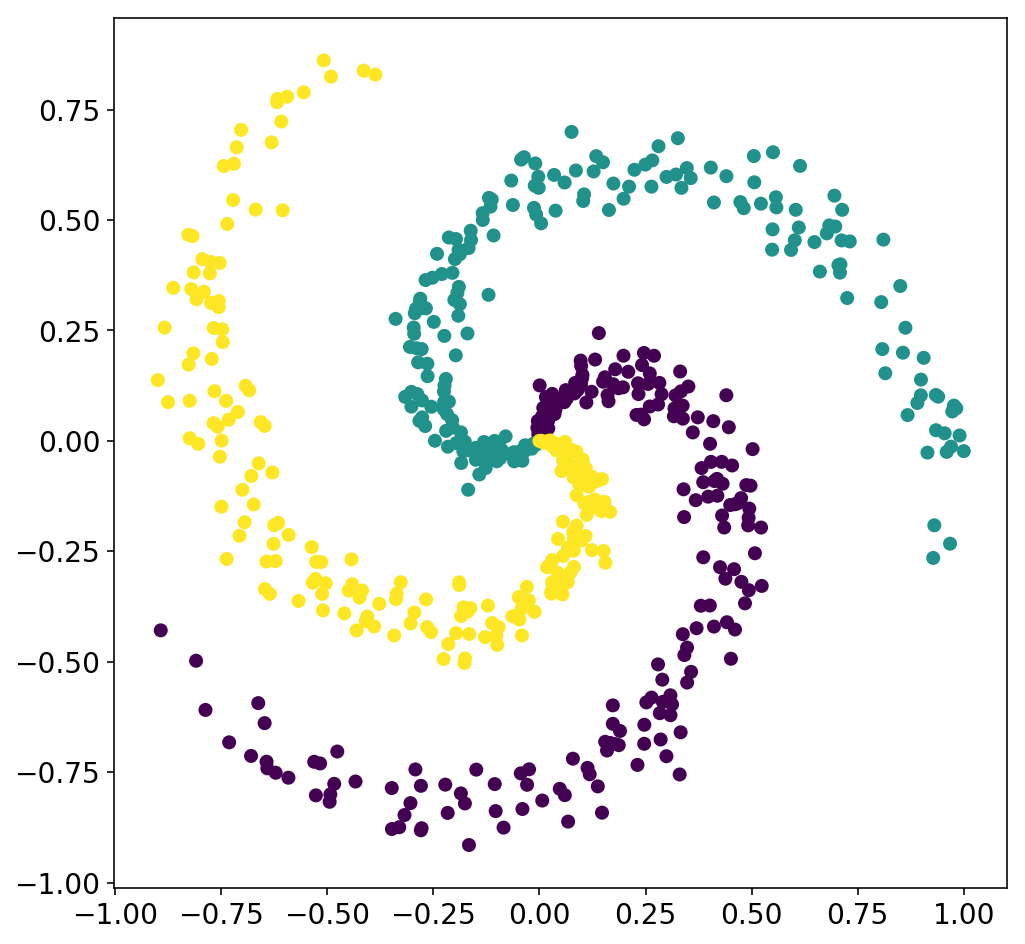

In [3]:
X,y = make_spiral()
plt.scatter(X[:,0],X[:,1],c=y)

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, random_state=42)

In [310]:
import utils
#solver='adam'
solver='sgd'

activation='relu'
#activation='tanh'

hidden_layer_sizes=(20,20)        
nnet = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, 
                         activation=activation, 
                         solver=solver,
                         alpha=alpha,
                         learning_rate_init=learning_rate_init,
                         max_iter=max_iter,
                         random_state=random_state)

nnet.fit(X_train,y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(20, 20), learning_rate='constant',
       learning_rate_init=0.1, max_iter=500, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='sgd', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

0.945833333333
[0 2 2 0 0 1 1 2 0 1 0 0 0 2 1 1 0 1 0 0 1 2 2 2 1 2 0 0 2 2 2 0 0 1 0 2 0
 2 2 1 1 0 2 2 0 0 2 0 0 2 1 1 0 2 2 1 1 0 0 2 0 0 1 2 2 0 2 2 0 1 1 1 2 1
 2 2 1 1 2 2 1 2 2 1 0 0 0 1 1 1 1 2 0 1 1 1 1 1 2 0 0 1 2 1 0 2 0 1 1 2 0
 2 2 2 1 1 1 0 2 2 0 1 1 2 0 0 2 1 2 2 0 2 0 0 2 0 0 0 1 0 1 1 0 0 2 0 1 2
 0 1 2 2 1 1 2 1 1 2 0 0 1 1 1 2 1 0 1 1 2 1 1 1 2 1 0 0 2 0 0 1 0 1 2 2 2
 1 1 2 1 1 2 2 0 1 2 1 2 1 2 0 0 2 2 0 1 1 1 1 1 2 2 2 2 0 1 0 1 1 2 1 0 2
 0 1 1 2 1 1 0 1 0 2 1 2 2 0 2 1 2 1]


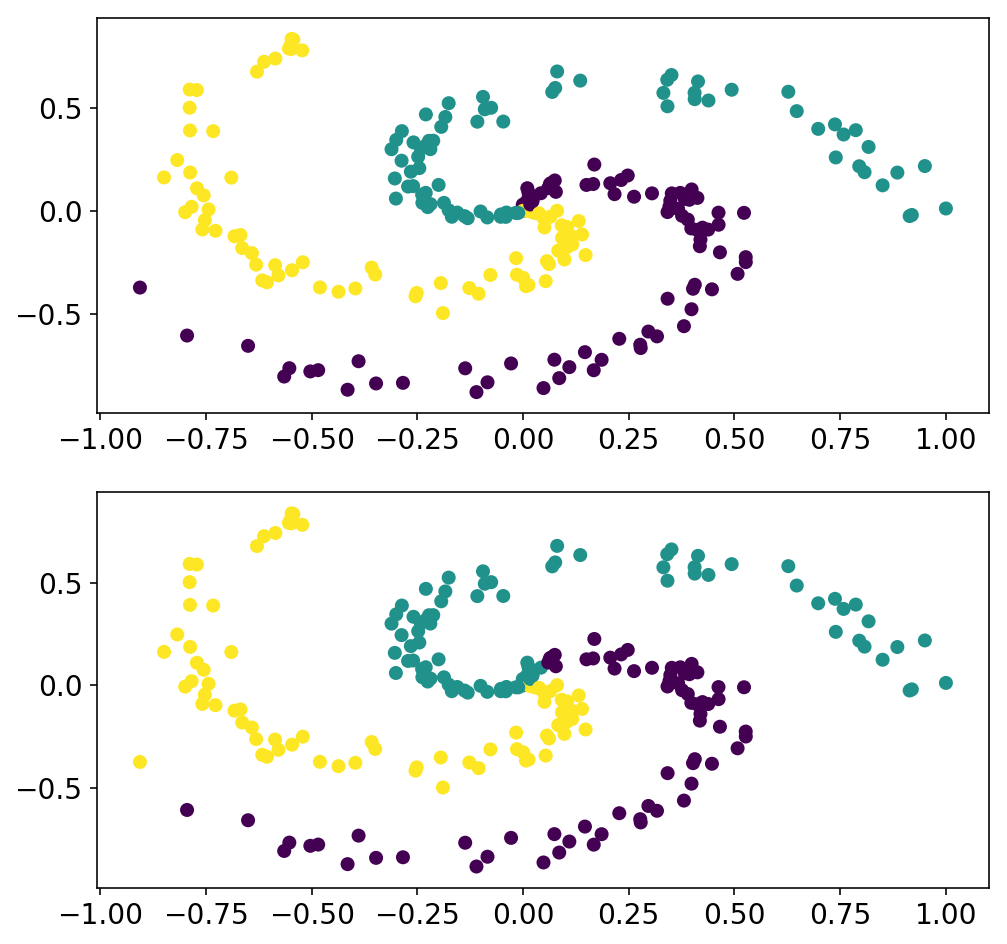

In [313]:
print(nnet.score(X_test,y_test))
predictions = nnet.predict(X_test)
plt.subplot(211)
plt.scatter(X_test[:,0],X_test[:,1],c=y_test)
predictions = nnet.predict(X_test)
plt.subplot(212)
plt.scatter(X_test[:,0],X_test[:,1],c=predictions)
#print(predictions)

In [348]:
## GRID SEARCH

solvers = ['adam', 'sgd']
activations = ['tanh','relu']
layer_sizes = [4,7,10,15,20]

# L2 REGULARIZATION PARAMETER
alpha=0.0001

# LEARNING RATE
#batch_size='auto'
#learning_rate='constant'
learning_rate_init=0.05
max_iter=800

# REPRODUCIBILITY
random_state = 42

#Single layer
for solver in solvers:
    for activation in activations:
        for layer_size in layer_sizes:
            hidden_layer_sizes = (layer_size,)
            nnet = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, 
                         activation=activation, 
                         solver=solver,
                         alpha=alpha,
                         learning_rate_init=learning_rate_init,
                         max_iter=max_iter,
                         random_state=random_state)
            
            nnet.fit(X_train,y_train)
            print('',solver, activation, hidden_layer_sizes, nnet.score(X_test,y_test),'',sep='| ')
            
#Two layers
for solver in solvers:
    for activation in activations:
        for layer_size_1 in layer_sizes:
            for layer_size_2 in layer_sizes:
                hidden_layer_sizes = (layer_size_1,layer_size_2)
                nnet = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, 
                             activation=activation, 
                             solver=solver,
                             alpha=alpha,
                             learning_rate_init=learning_rate_init,
                             max_iter=max_iter,
                             random_state=random_state)

                nnet.fit(X_train,y_train)
                print('',solver, activation, hidden_layer_sizes, nnet.score(X_test,y_test),'',sep='| ') 
                
#Three layers
for solver in solvers:
    for activation in activations:
        for layer_size_1 in layer_sizes:
            for layer_size_2 in layer_sizes:
                for layer_size_3 in layer_sizes:
                    hidden_layer_sizes = (layer_size_1,layer_size_2,layer_size_3)
                    nnet = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, 
                                 activation=activation, 
                                 solver=solver,
                                 alpha=alpha,
                                 learning_rate_init=learning_rate_init,
                                 max_iter=max_iter,
                                 random_state=random_state)

                    nnet.fit(X_train,y_train)
                    print('',solver, activation, hidden_layer_sizes, nnet.score(X_test,y_test),'',sep='| ')

| adam| tanh| (4,)| 0.916666666667| 
| adam| tanh| (7,)| 0.983333333333| 
| adam| tanh| (10,)| 0.979166666667| 
| adam| tanh| (15,)| 0.5375| 
| adam| tanh| (20,)| 0.533333333333| 
| adam| relu| (4,)| 0.579166666667| 
| adam| relu| (7,)| 0.983333333333| 
| adam| relu| (10,)| 0.991666666667| 
| adam| relu| (15,)| 0.979166666667| 
| adam| relu| (20,)| 0.925| 
| sgd| tanh| (4,)| 0.754166666667| 
| sgd| tanh| (7,)| 0.954166666667| 
| sgd| tanh| (10,)| 0.9625| 
| sgd| tanh| (15,)| 0.966666666667| 
| sgd| tanh| (20,)| 0.525| 
| sgd| relu| (4,)| 0.529166666667| 
| sgd| relu| (7,)| 0.866666666667| 


/Users/cremones/anaconda3/envs/advancedComputing/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


| sgd| relu| (10,)| 0.975| 
| sgd| relu| (15,)| 0.9375| 
| sgd| relu| (20,)| 0.858333333333| 
| adam| tanh| (4, 4)| 0.975| 
| adam| tanh| (4, 7)| 0.991666666667| 
| adam| tanh| (4, 10)| 0.983333333333| 
| adam| tanh| (4, 15)| 0.979166666667| 
| adam| tanh| (4, 20)| 0.991666666667| 
| adam| tanh| (7, 4)| 0.975| 
| adam| tanh| (7, 7)| 0.975| 
| adam| tanh| (7, 10)| 0.9875| 
| adam| tanh| (7, 15)| 0.983333333333| 
| adam| tanh| (7, 20)| 0.541666666667| 
| adam| tanh| (10, 4)| 0.979166666667| 
| adam| tanh| (10, 7)| 0.9875| 
| adam| tanh| (10, 10)| 0.954166666667| 
| adam| tanh| (10, 15)| 0.9875| 
| adam| tanh| (10, 20)| 0.983333333333| 
| adam| tanh| (15, 4)| 0.983333333333| 
| adam| tanh| (15, 7)| 0.979166666667| 
| adam| tanh| (15, 10)| 0.983333333333| 
| adam| tanh| (15, 15)| 0.979166666667| 
| adam| tanh| (15, 20)| 0.983333333333| 
| adam| tanh| (20, 4)| 0.991666666667| 
| adam| tanh| (20, 7)| 0.975| 
| adam| tanh| (20, 10)| 0.983333333333| 
| adam| tanh| (20, 15)| 0.9875| 
| adam| ta

In [340]:
import utils
#solver='adam'
solver='sgd'

activation='relu'
#activation='tanh'

hidden_layer_sizes=(7,7)        
nnet = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, 
                         activation=activation, 
                         solver=solver,
                         alpha=alpha,
                         learning_rate_init=learning_rate_init,
                         max_iter=max_iter,
                         random_state=random_state)

nnet.fit(X_train,y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(7, 7), learning_rate='constant',
       learning_rate_init=0.1, max_iter=500, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='sgd', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

0.916666666667


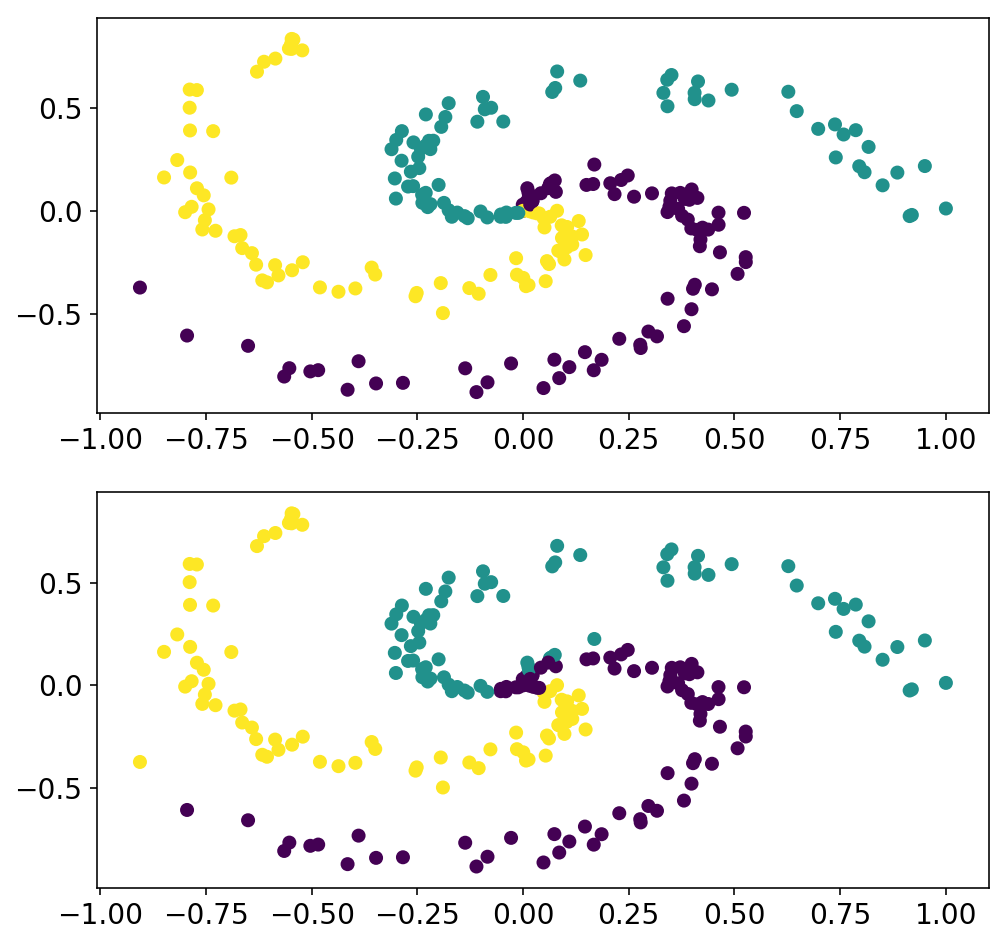

In [341]:
print(nnet.score(X_test,y_test))
predictions = nnet.predict(X_test)
plt.subplot(211)
plt.scatter(X_test[:,0],X_test[:,1],c=y_test)
predictions = nnet.predict(X_test)
plt.subplot(212)
plt.scatter(X_test[:,0],X_test[:,1],c=predictions)

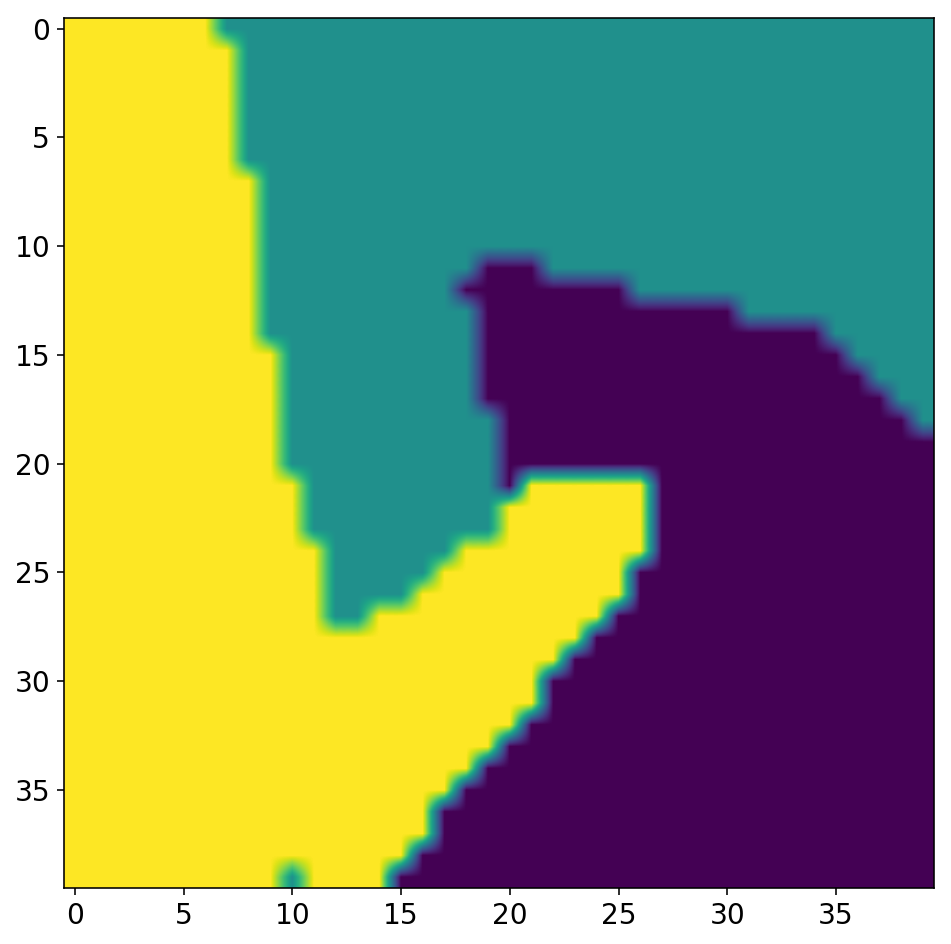

In [333]:
xx = np.arange(start=-1.0,stop=1.0,step=0.05)
yy = np.arange(start=-1.0,stop=1.0,step=0.05)

surface = np.zeros(shape=(len(xx),len(yy)))

for i,x in enumerate(xx):
    for j,y in enumerate(yy):
        pred = nnet.predict(np.array([x,y]).reshape((1,-1)))       
        surface[i,j] = ((pred+2)%3)/2.0
        
plt.imshow(surface,interpolation='bilinear')

In [6]:
import keras

Using Theano backend.


In [41]:
from keras.models import Sequential
from keras.layers.core import Dense

model = Sequential()
model.add(Dense(7, input_dim=2, activation='tanh'))
model.add(Dense(7, activation='tanh'))
model.add(Dense(3, activation='softmax'))

In [42]:
from keras.utils.np_utils import to_categorical

categorical_labels = to_categorical(y_train, num_classes=None)

model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [43]:
print(X_train.shape)
print(categorical_labels.shape)

(360, 2)
(360, 3)


In [48]:
# Following https://keras.io/getting-started/sequential-model-guide/

# Going to create a (7,7) network, but I need to add a softmax layer for the decision function in the end

model = Sequential()
model.add(Dense(7, activation='tanh', input_dim=2))
model.add(Dense(7, activation='tanh'))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Convert labels to categorical one-hot encoding
one_hot_labels = keras.utils.to_categorical(y_train, num_classes=3)

# Train the model, iterating on the data in batches of 32 samples
model.fit(X_train, one_hot_labels, epochs=1000, batch_size=32)

Epoch 1/1000
360/360 [==============================] - 0s - loss: 1.0474 - acc: 0.4028     
Epoch 2/1000
360/360 [==============================] - 0s - loss: 1.0355 - acc: 0.4167     
Epoch 3/1000
360/360 [==============================] - 0s - loss: 1.0242 - acc: 0.4222     
Epoch 4/1000
360/360 [==============================] - 0s - loss: 1.0134 - acc: 0.4278     
Epoch 5/1000
360/360 [==============================] - 0s - loss: 1.0036 - acc: 0.4306     
Epoch 6/1000
360/360 [==============================] - 0s - loss: 0.9943 - acc: 0.4389     

In [54]:
one_hot_test_labels = keras.utils.to_categorical(y_test, num_classes=3)
score = model.evaluate(X_test, one_hot_test_labels, batch_size=32)
print()
print(score[1])

 32/240 [===>..........................] - ETA: 0s
0.904166666667


---

## Question 3

Build a fully connected neural network and a ConvNet to classify hand written digits.

scikit-learn's NN implementation does not support convolutional layers so it is probably
best to implement both using `keras`.

Experiment with different network architectures, different optimisers and such.

You should be able to achieve accuracies > 95% pretty quickly. With a bit of experimenting
you can probably reach 98% or 99%.

This question is about getting you comfortable using `keras` and constructing networks
from basic building blocks. Feel free to experiment, brnach out and try different things.

Note: this might take a while to train, unfortunately.

## Summary of results

I was able to implement both, mainly thanks to the already existing examples on the keras github page. The main problems I had each time was with the dimensions of tensors, often if things aren't exactly as keras expects, you get some obscure errors about the shapes of the tensor in the very last layer. 

The convolutional model outperforms the fully connected one by a lot. To be fair though, I had to make both models very small to prevent my computer from dying.

In [1]:
import keras

Using Theano backend.


In [22]:
# loading the MNIST (or digits) dataset in keras
from keras.datasets import mnist

# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# the first time you run this you need to have internet so it can download the data
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[2])

X_train = X_train/255.0
X_test = X_test/255.0
print(X_train[0,0])

0.0


In [23]:
# some of the layers we discussed in class, checkout the documentation if you need more
# or want to experiment
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

# your solution

In [24]:
print(X_train.shape)
print(y_train[:10])

(60000, 784)
[5 0 4 1 9 2 1 3 1 4]


In [25]:
# Following https://keras.io/getting-started/sequential-model-guide/
# and https://github.com/fchollet/keras/tree/master/examples

model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(784,)))
model.add(Dense(512, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Convert labels to categorical one-hot encoding
one_hot_labels = keras.utils.to_categorical(y_train, num_classes=10)

# Train the model, iterating on the data in batches of 32 samples
model.fit(X_train, one_hot_labels, epochs=8, batch_size=600, verbose=1)

Epoch 1/8
60000/60000 [==============================] - 3s - loss: 1.9726 - acc: 0.5142     

In [26]:
score = model.evaluate(X_test, one_hot_labels_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.390677793407
Test accuracy: 0.8976


In [15]:
# loading the MNIST (or digits) dataset in keras
from keras.datasets import mnist

# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

one_hot_labels_train = keras.utils.to_categorical(y_train, num_classes=10)
one_hot_labels_test = keras.utils.to_categorical(y_test, num_classes=10)

# the first time you run this you need to have internet so it can download the data
X_train = X_train.reshape(X_train.shape[0],28,28,1)
X_test = X_test.reshape(X_test.shape[0],28,28,1)

X_train = X_train/255.0
X_test = X_test/255.0

print(X_train[0,0,0,0])

0.0


In [14]:
from keras import backend as K
print(K.image_data_format())

channels_last


In [20]:
# and https://github.com/fchollet/keras/tree/master/examples

model = Sequential()
model.add(Conv2D(8, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28,28,1)))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adagrad(),
              metrics=['accuracy'])

model.fit(X_train, one_hot_labels_train,
          batch_size=600,
          epochs=8,
          verbose=1) #,
#          validation_data=(x_test, y_test))


INFO (theano.gof.compilelock): Refreshing lock /Users/cremones/.theano/compiledir_Darwin-14.5.0-x86_64-i386-64bit-i386-3.6.1-64/lock_dir/lock


Epoch 1/8
60000/60000 [==============================] - 70s - loss: 0.4172 - acc: 0.8740     

In [21]:
score = model.evaluate(X_test, one_hot_labels_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

INFO (theano.gof.compilelock): Refreshing lock /Users/cremones/.theano/compiledir_Darwin-14.5.0-x86_64-i386-64bit-i386-3.6.1-64/lock_dir/lock


Test loss: 0.0472861101405
Test accuracy: 0.9834
